# Hyperskill python dataset analysis

## Settings

In [2]:
import pandas as pd
import numpy as np

from typing import List, Dict
import string
import sys
import os

import importlib

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style='whitegrid', font_scale=2, rc={"lines.linewidth": 5, "lines.markersize": 15})

In [3]:
module_path = os.path.abspath(os.path.join('../../../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import analysis
importlib.reload(analysis)

from analysis.src.python.data_analysis.analysis.attrs import draw_base_attrs

from analysis.src.python.data_analysis.analysis.statistics import \
    get_submissions_percent_by_issues, get_client_stats, \
    get_submissions_series_dynamic_by_feature, get_submissions_series_issues_dynamic, \
    get_top_issues, get_submissions_percent_by_feature, \
    get_submissions_series_client_dynamic

from analysis.src.python.data_analysis.analysis.plots import \
    draw_compare, draw_heatmap_compare, \
    draw_hist_plots, draw_count_plots, \
    draw_stat_plot, draw_client_dynamic_graph

from analysis.src.python.data_analysis.stat_test.iticse_2022.rq_stat_tests import run_stat_tests

/Users/tiginamaria1999/PycharmProjects/hyperstyle-analyze/venv/src/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [4]:
def merge_dfs(df_left: pd.DataFrame, df_right: pd.DataFrame, left_on: str, right_on: str) -> pd.DataFrame:
    df_merged = pd.merge(df_left, df_right, left_on=left_on, right_on=right_on, suffixes=('', '_extra'))
    df_merged.drop(df_merged.filter(regex='_extra$').columns.tolist(), axis=1, inplace=True)
    return df_merged

In [5]:
def get_tag(count, scope_borders, labels) -> str:
    if count <= scope_borders[0]:
        return labels[0]
    if count >= scope_borders[1]:
        return labels[2]
    return labels[1]

### Set path to following csv files (or use preset default)

In [6]:
data_directory_path = '/Users/tiginamaria1999/PycharmProjects/hyperstyle-analyze/analysis/src/resources/data/python_test'
users_file_path = os.path.join(data_directory_path, 'users.csv')
steps_file_path = os.path.join(data_directory_path, 'steps.csv')
topics_file_path = os.path.join(data_directory_path, 'topics.csv')

submissions_file_path = os.path.join(data_directory_path, 'solutions_python3_filtered.csv')
submissions_stats_file_path = os.path.join(data_directory_path, 'solutions_python3_filtered_stats.csv')
client_stats_file_path = os.path.join(data_directory_path, 'solutions_python3_filtered_client_stats.csv')

hyperstyle_issues_stats_file_path = os.path.join(data_directory_path, 'solutions_python3_filtered_issues_stats.csv')
hyperstyle_issues_classes_file_path = os.path.join(data_directory_path, 'hyperstyle_issues.csv')


### Color pallents of main attributes

difficulty
easy -> medium -> hard


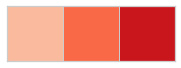

complexity
shallow -> middle -> deep


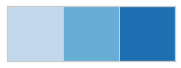

scope
small -> medium -> wide


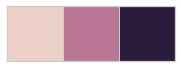

level
low -> average -> high


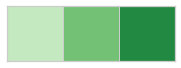

client
idea -> web


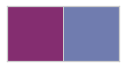

In [7]:
draw_base_attrs()

# Steps and Topics
**Step** - is a task where user is asked to write some code. Main attributes:
* `id` - *identifier of step*
* `seconds_to_complete` - *estimated secons to complete (calculated as average from all successful sumbissions)*
* `solved_by` - *number of successful sumbissions*
* `success_rate` - *number of successful sumbissions dvided by total number of sumbissions*
* `topic_id` - *id of topic step is related to. By this id we can define step's `depth` and `prerequisites_count` by related topic's `depth` and `prerequisites_count`*
* `difficulty` - [`easy`, `medium`, `hard`] *according to success_rate [sr<=0.33, 0.33<sr<0.66, sr>=0.66]*. This value is defeined in planform and calculated there for each step according this rule.
* `complexity` - [`shallow`, `middle`, `deep`] *according to topic depth [d<=2, 2<d<5, d>=5]*. Borders was selected as 0.25 and 0.75 quantiles.
* `scope` - [`small`, `medium`, `wide`] *according to prerequisites_count [pc<=6, 6<pc<42, pc>=42]*. Borders was selected as 0.25 and 0.75 quantiles.

**Topic** - is a theme or knowledge area. Every step is related to some topic. Main attributes:
* `id` - *identifier of step*
* `prerequisites` - *topics ids which must be leared before*
* `depth` - *the depth in topics tree*
* `prerequisites_count` - *number of all prerequisite topics in topics tree (subtree size)*

In [8]:
df_steps = pd.read_csv(steps_file_path)
df_steps[['id', 'success_rate', 'depth', 'prerequisites_count']].describe(percentiles=[0.25, 0.5, 0.75])

id  success_rate       depth  prerequisites_count
count    364.000000    364.000000  364.000000           364.000000
mean    9051.164835      0.486664    3.810440            18.368132
std     2709.851774      0.144660    2.118995            19.314468
min     5205.000000      0.059000    0.000000             0.000000
25%     6718.250000      0.381750    2.000000             5.000000
50%     8440.500000      0.456500    3.500000            11.000000
75%    10791.250000      0.594320    5.000000            26.000000
max    15188.000000      0.885000   10.000000            78.000000

In [9]:
df_steps['complexity'] = df_steps['depth'].apply(get_tag, scope_borders=[2, 5], labels=['shallow', 'middle', 'deep'])
df_steps['scope'] = df_steps['prerequisites_count'].apply(get_tag, scope_borders=[5, 26], labels=['small', 'medium', 'wide'])
df_steps.to_csv(steps_file_path)

## Steps statistics description

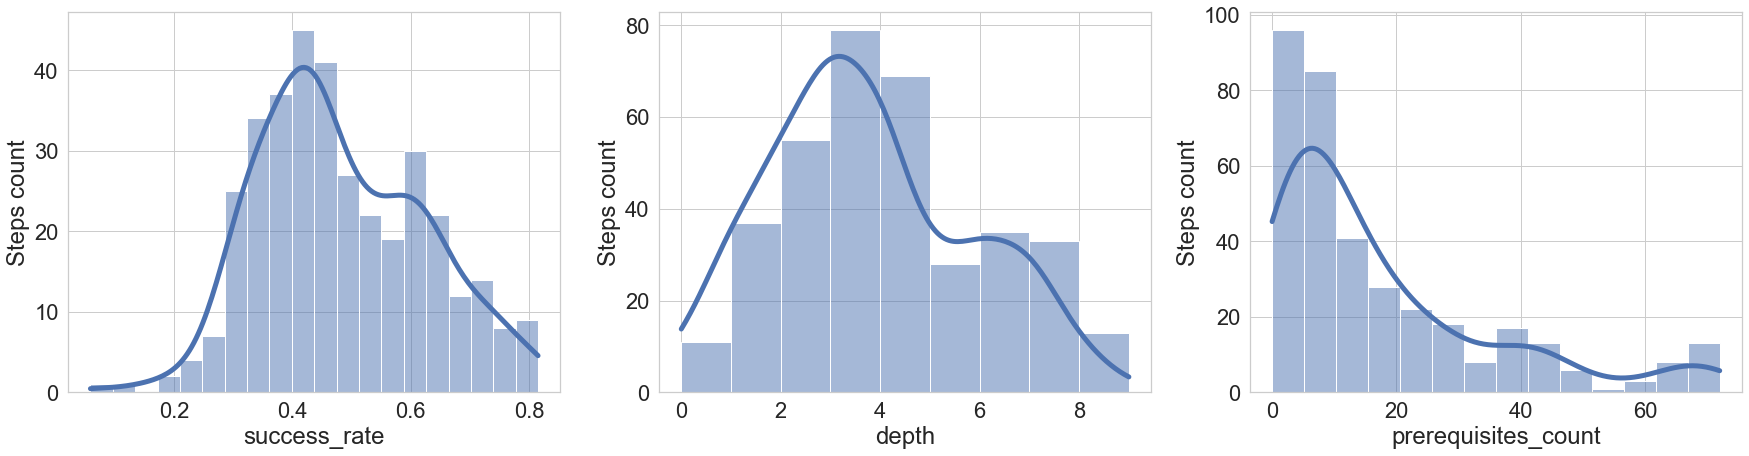

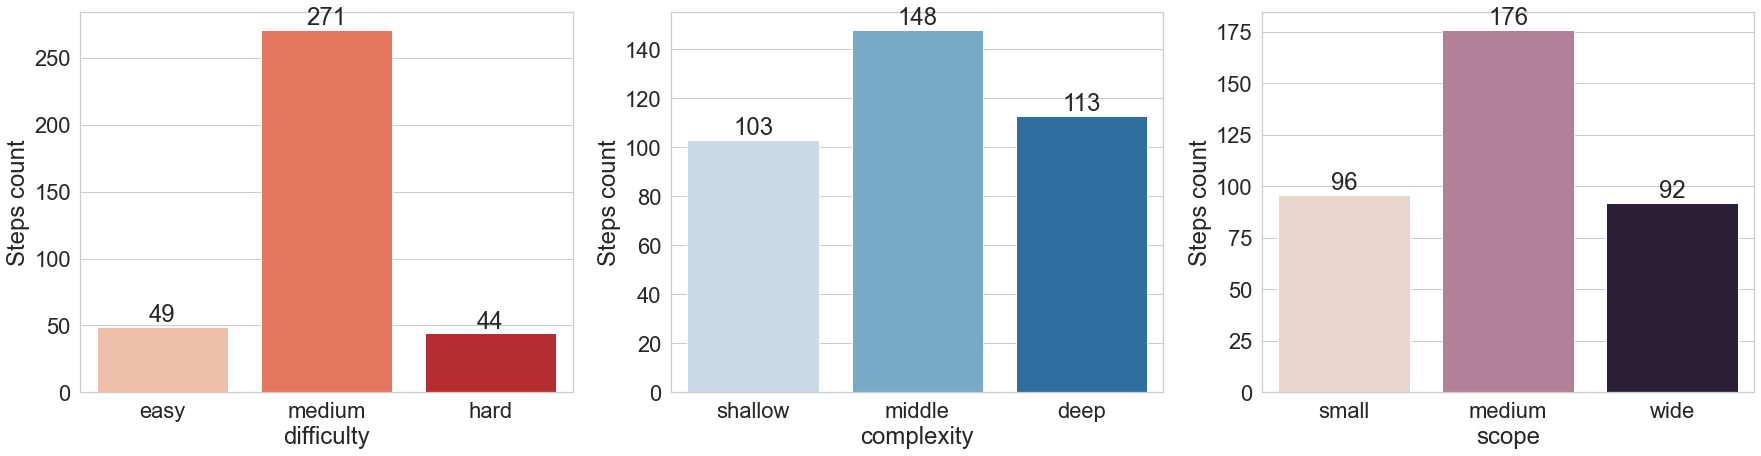

In [10]:
draw_hist_plots(df_steps, ['success_rate', 'depth', 'prerequisites_count'], 
                columns=3, log_scale=False, kde=True, y_label='Steps count')
draw_count_plots(df_steps, ['difficulty', 'complexity', 'scope'], 
                 columns=3, y_label='Steps count')

# Users

* `id` - *identifier of user*
* `passed_theories` - *number of passed theories steps*
* `passed_problems` - *number of passed problems*
* `passed_topics` - *number of passed topics*
* `passed_stages` - *number of passed stages*
* `passed_projects` - *number of passed projects*
* `hypercoins` - *number of collected hypercoins*
* `active_days` - *number of active days*
* `max_streak` - *max streak*
* `level` - `[low, average, high]` *according to passed_topics [tp<=3, 20<tp<56, tp>=56]*. Borders was selected as 0.25 and 0.75 quantiles.


In [11]:
df_users = pd.read_csv(users_file_path)
df_users.describe().astype('int32')

Unnamed: 0  Unnamed: 0.1     id  passed_theories  passed_problems  \
count        3145          3145   3145             3145             3145   
mean         1572          1572  16583              124              675   
std           908           908  11958              139              899   
min             0             0      3                1                1   
25%           786           786   6417               30              120   
50%          1572          1572  14515               76              358   
75%          2358          2358  26456              168              861   
max          3144          3144  82097             1143             8834   

       passed_topics  passed_stages  passed_projects  hypercoins  active_days  \
count           3145           3145             3145        3145         3145   
mean             124             25                3         821           47   
std              139             41                7        1451           71   
min                0              0                0           0            0   
25%               28              3                0         189            7   
50%               76             11                1         363           22   
75%              169             29                4         808           56   
max             1155            525              109       28201          680   

       max_streak  
count        3145  
mean           13  
std            33  
min             0  
25%             3  
50%             6  
75%            11  
max           715

In [12]:
df_users['level'] = df_users['passed_topics'].apply(get_tag, 
                                                    scope_borders=[28, 169],
                                                    labels=['low', 'average', 'high'])
df_users.to_csv(users_file_path)

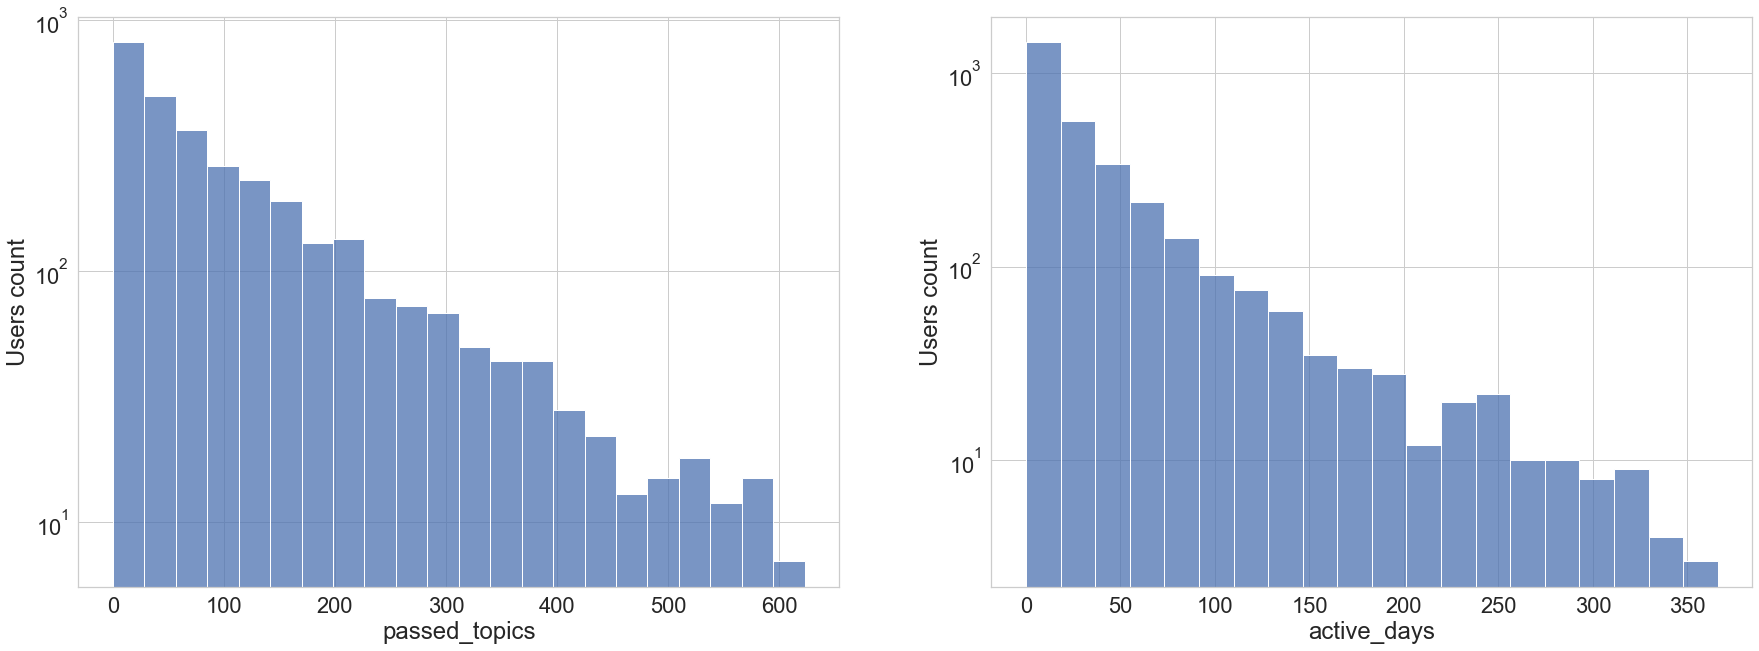

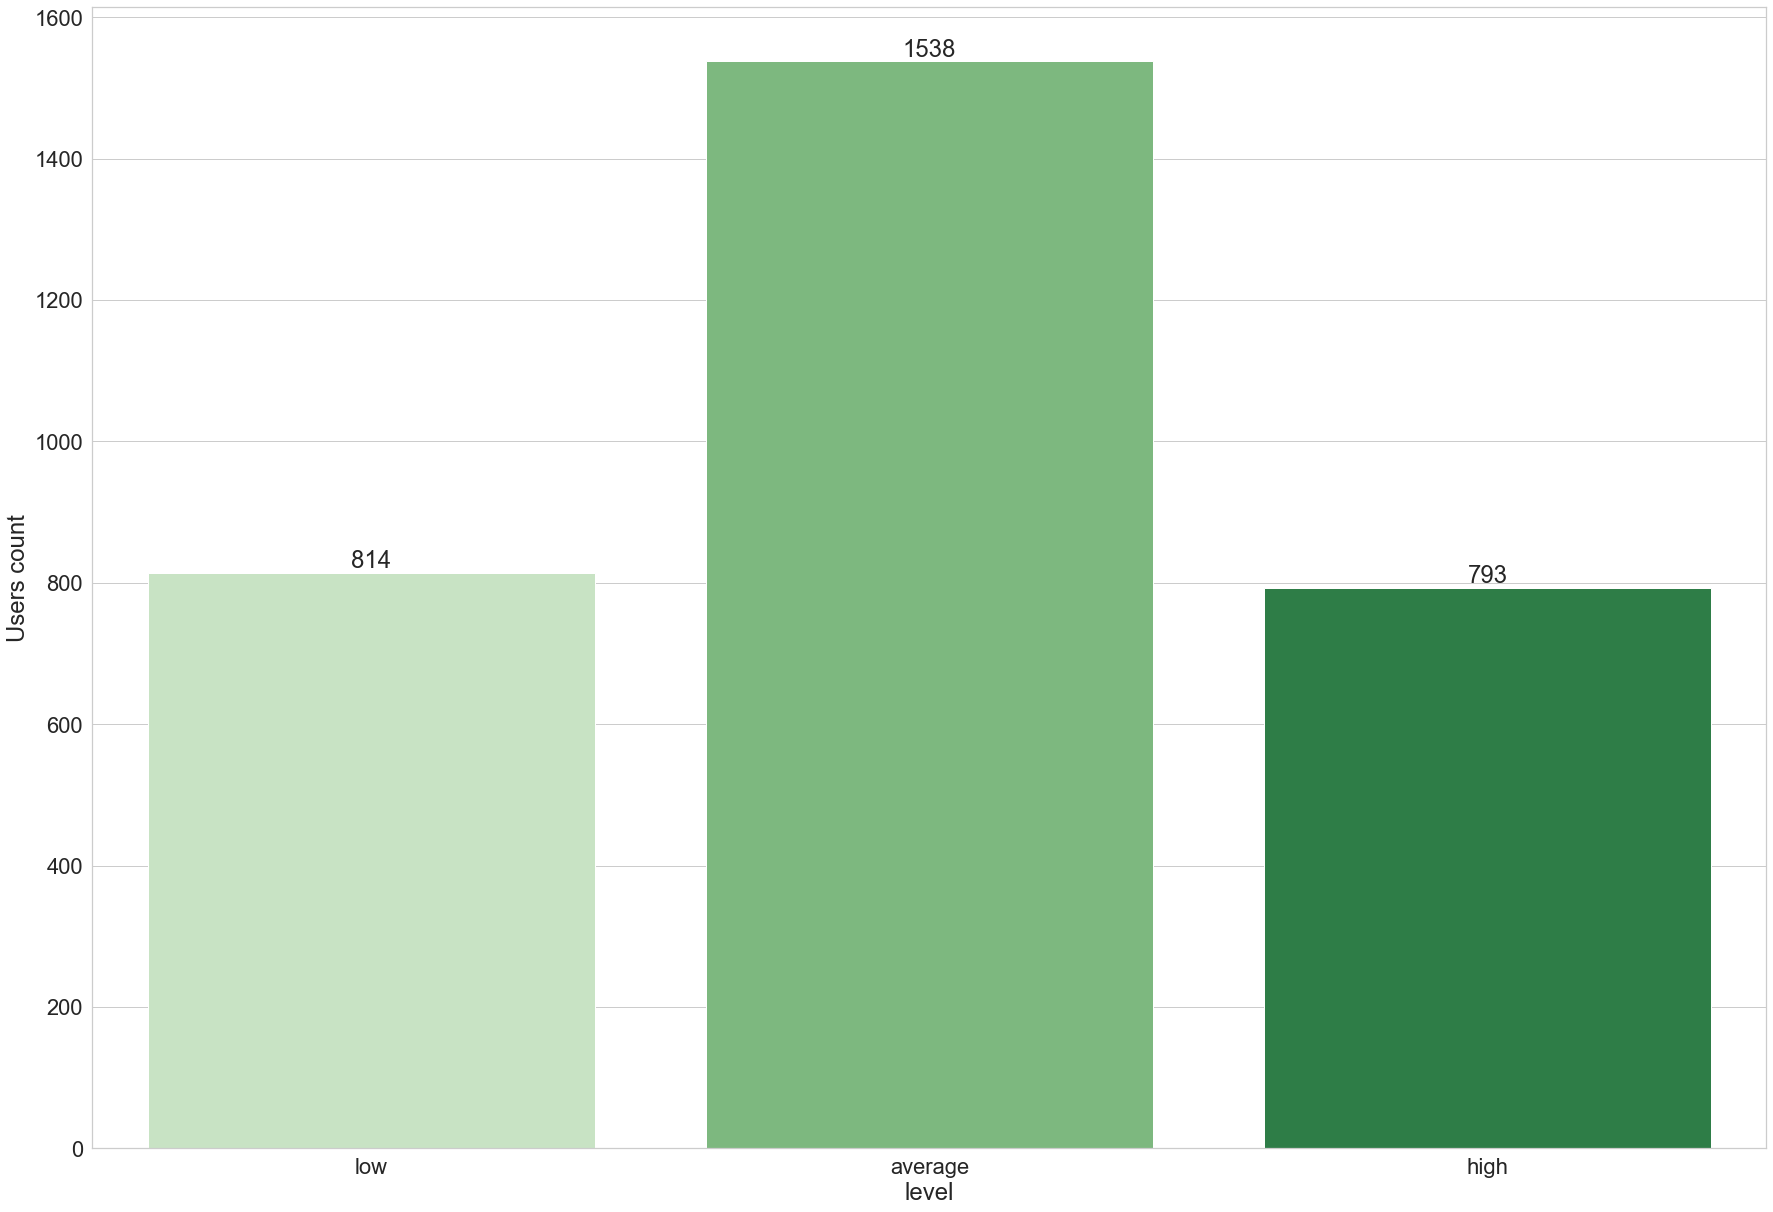

In [13]:
draw_hist_plots(df_users, ['passed_topics', 'active_days'], log_scale=(False, True), y_label='Users count')
draw_count_plots(df_users, ['level'], columns=1, y_label='Users count')

## Submissions

Submission is an attempt of user to pass step's task. One user can do several attempts to pass one step.

* `id` - *identifier of submission*
* `step_id` - *identifier of step*
* `user_id` - *identifier of user*
* `group` - *number of submission series (group of submissions on one step by one user)*
* `attempt` - *number of attempt inside submission series*
* `total_attempt` - *number of attempts is submission series*
* `base_client` - `[web, idea, ide, IdeaEdu, Idea]` *interface from which submission was submitted*
* `client` - `[web, idea]` *interface group from which submission was submitted*

In [14]:
df_submissions = pd.read_csv(submissions_file_path)
df_submissions.describe().astype('int32')

id  step_id  sync_counter  user_id    group  attempt  \
count    138877   138877        138877   138877   138877   138877   
mean   42683749     7364             4    14626   105655        1   
std     7723761     1644             1    11859    80041        0   
min    29383302     5205             2        3        2        1   
25%    35728751     6404             4     4223    52769        1   
50%    42706576     6814             5    12241   104529        1   
75%    49529657     8213             5    21792   153842        1   
max    56397107    15188            19    82097  1722213        5   

       total_attempts  
count          138877  
mean                1  
std                 0  
min                 1  
25%                 1  
50%                 1  
75%                 1  
max                 5

### Sumbission client distriburion
In platform student can use `web` indeface for typing code or `ide`.
This plot shows that around 2/3 of the sumbisssions are done in `web` indeface. 

<AxesSubplot:xlabel='client', ylabel='Count'>

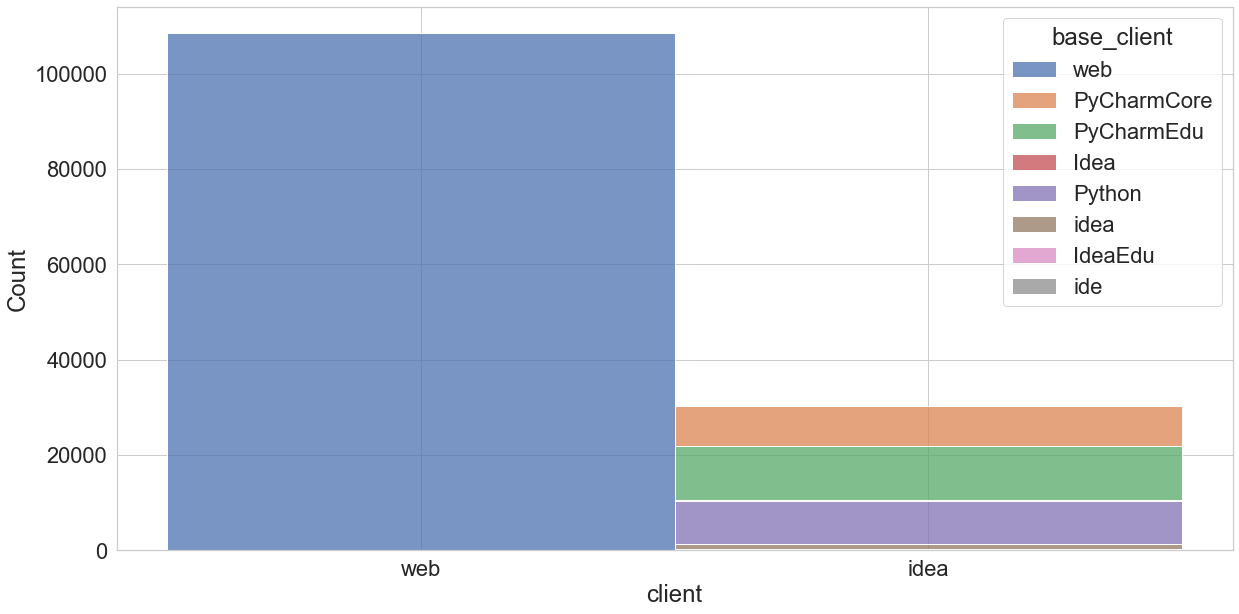

In [15]:
fig, ax = plt.subplots(figsize=((20, 10)))
sns.histplot(data=df_submissions, x='client', hue='base_client', multiple='stack')

## Submission statistics
* `code_lines_count` - number of code lines
* `code_symbols_count` - number of code symbols
* `hyperstyle_issues_count` - number of raw issues
* `hyperstyle_issues_by_code_lines` - number of raw issues divided by code lines
* `qodana_issues_by_code_lines` - number of qodana issues divided by code lines

In [16]:
df_submissions_stats = pd.read_csv(submissions_stats_file_path)
df_submissions_stats.describe().astype('int32')

id  code_lines_count  code_symbols_count  \
count    138877            138877              138877   
mean   42683749                 6                 132   
std     7723761                 4                 126   
min    29383302                 1                   8   
25%    35728751                 4                  51   
50%    42706576                 6                  96   
75%    49529657                 9                 172   
max    56397107                89                3264   

       hyperstyle_issues_count  hyperstyle_issues_by_code_lines  
count                   138877                           138877  
mean                         1                                0  
std                          5                                1  
min                          0                                0  
25%                          0                                0  
50%                          1                                0  
75%                          2                                0  
max                        443                              210

In [17]:
df_submissions_stats = merge_dfs(df_submissions_stats, df_submissions, left_on='id', right_on='id')
df_submissions_stats = merge_dfs(df_submissions_stats, df_steps[['id', 'complexity', 'difficulty', 'scope']], left_on='step_id', right_on='id')
df_submissions_stats = merge_dfs(df_submissions_stats, df_users[['id', 'level']], left_on='user_id', right_on='id')

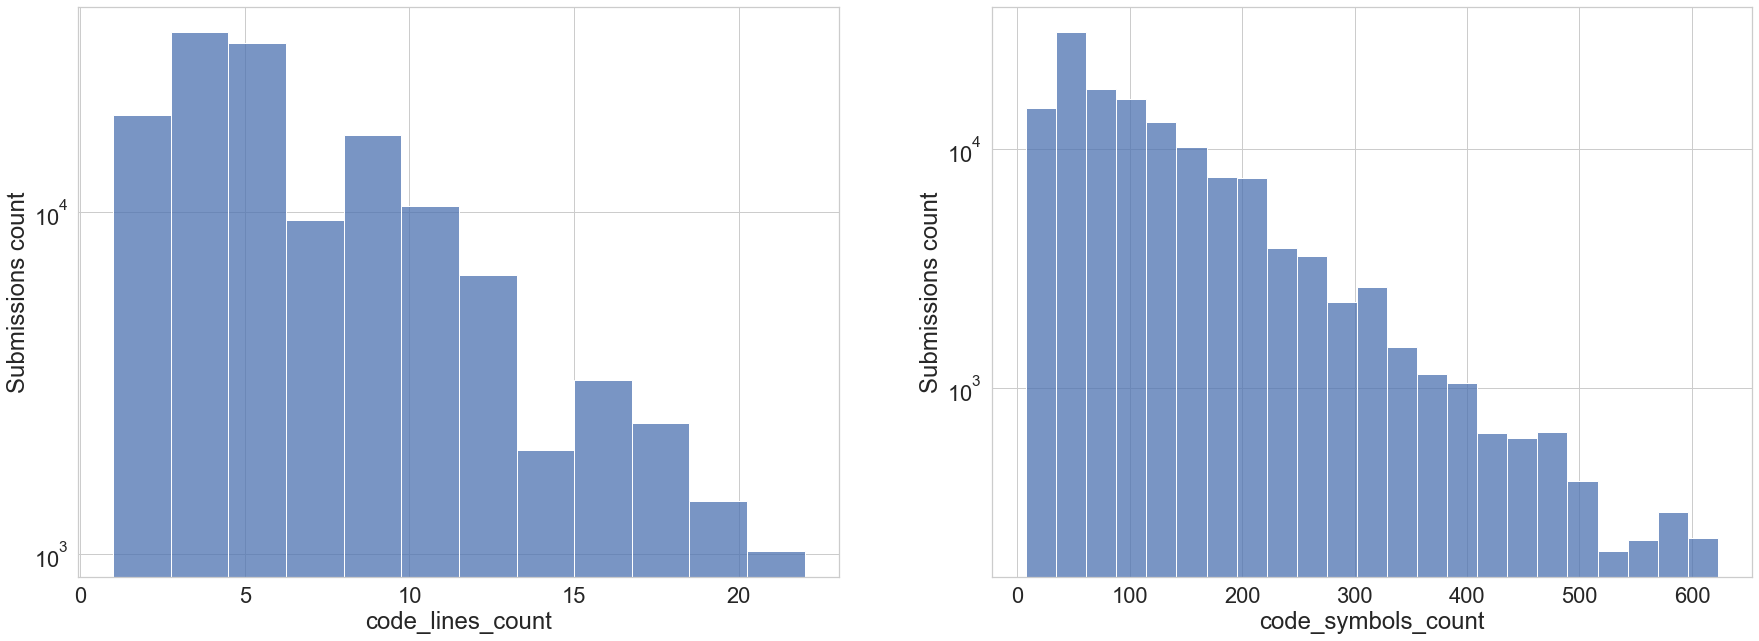

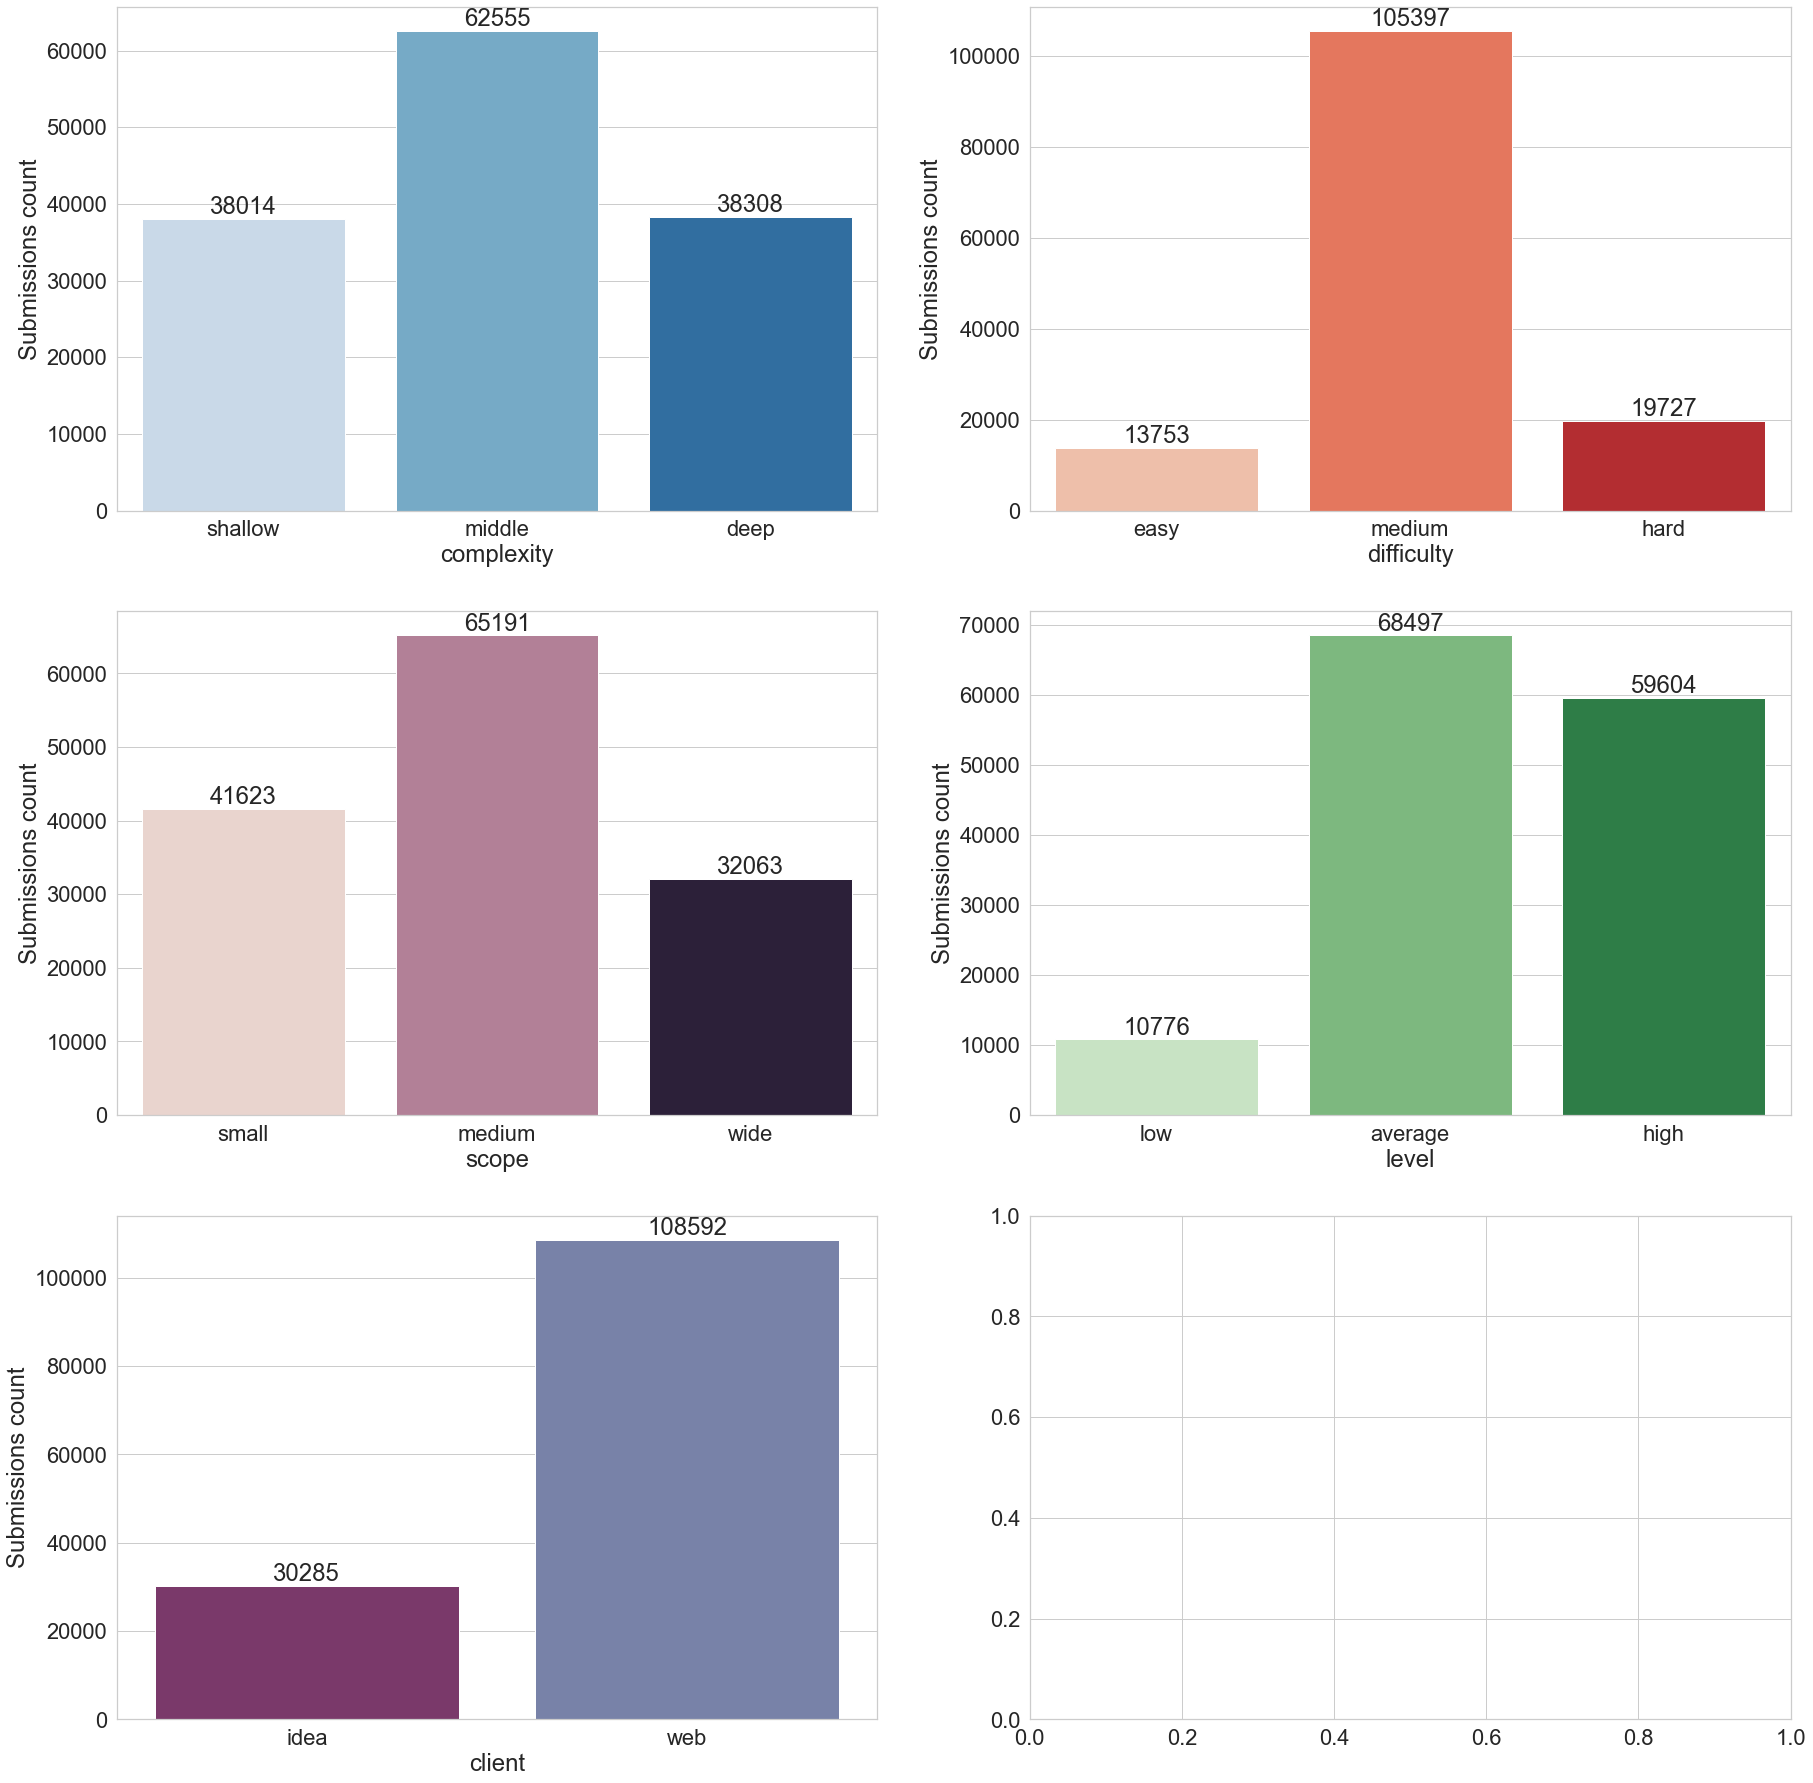

In [18]:
draw_hist_plots(df_submissions_stats, ['code_lines_count', 'code_symbols_count'], 
                columns=2, log_scale=(False, True), y_label='Submissions count')

draw_count_plots(df_submissions_stats, ['complexity', 'difficulty', 'scope', 'level', 'client'], y_label='Submissions count')

# Hyperstyle code quality issue analysis

We invoked Hyperstyle code quality tool on each submissions and got a code quality report with list of detected issues in submission `hypertyle_issues`. Hyperstyle issue is code quality error which has `name` e.x. MagicNumberCheck and `category` e.x. INFO. 

In a preprocessing part for each submission we calcaulated number of hypertyle issues of each name.

In [19]:
def draw_issues(df: pd.DataFrame, df_issues: pd.DataFrame, blur_issues, base_dir: str = 'results'):
    os.makedirs(base_dir, exist_ok=True)
    for attr in ['difficulty', 'complexity', 'level', 'client', 'scope']:
        df_stats = get_submissions_percent_by_issues(df, df_issues, attr, sort=False)
        df_stats.to_csv(os.path.join(base_dir, f'issues_stats_{attr}.csv'), index=False)
        draw_compare(df_stats, 
                     'issue', 
                     attr, blur_issues, 
                     save_path=os.path.join(base_dir, f'issues_stats_{attr}.png'))

In [20]:
df_hyperstyle_issues_stats = pd.read_csv(hyperstyle_issues_stats_file_path)
df_hyperstyle_issues_stats.describe()

id         WPS453          E265         WPS350  \
count  1.388770e+05  138877.000000  138877.00000  138877.000000   
mean   4.268375e+07       0.189801       0.01785       0.016403   
std    7.723762e+06       0.392145       0.19307       0.140889   
min    2.938330e+07       0.000000       0.00000       0.000000   
25%    3.572875e+07       0.000000       0.00000       0.000000   
50%    4.270658e+07       0.000000       0.00000       0.000000   
75%    4.952966e+07       0.000000       0.00000       0.000000   
max    5.639711e+07       1.000000      12.00000       4.000000   

                E261           E262         WPS432          C0325  \
count  138877.000000  138877.000000  138877.000000  138877.000000   
mean        0.009469       0.002830       0.253116       0.008943   
std         0.107422       0.064952       1.002210       0.136324   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         5.000000       5.000000      24.000000      10.000000   

                E111           E117  ...          W0604           F811  \
count  138877.000000  138877.000000  ...  138877.000000  138877.000000   
mean        0.002333       0.001959  ...       0.000036       0.000007   
std         0.080110       0.074918  ...       0.006000       0.002683   
min         0.000000       0.000000  ...       0.000000       0.000000   
25%         0.000000       0.000000  ...       0.000000       0.000000   
50%         0.000000       0.000000  ...       0.000000       0.000000   
75%         0.000000       0.000000  ...       0.000000       0.000000   
max        10.000000      10.000000  ...       1.000000       1.000000   

               E1121         WPS612          E1101          E0306  \
count  138877.000000  138877.000000  138877.000000  138877.000000   
mean        0.000007       0.000014       0.000022       0.000014   
std         0.002683       0.003795       0.008050       0.003795   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       3.000000       1.000000   

               E1305         WPS202          R1717          C0104  
count  138877.000000  138877.000000  138877.000000  138877.000000  
mean        0.000014       0.000007       0.000007       0.000007  
std         0.003795       0.002683       0.002683       0.002683  
min         0.000000       0.000000       0.000000       0.000000  
25%         0.000000       0.000000       0.000000       0.000000  
50%         0.000000       0.000000       0.000000       0.000000  
75%         0.000000       0.000000       0.000000       0.000000  
max         1.000000       1.000000       1.000000       1.000000  

[8 rows x 313 columns]

In [21]:
df_hyperstyle_issues_stats = merge_dfs(df_hyperstyle_issues_stats, df_submissions_stats, left_on='id', right_on='id')

During the analysis we desided to filter out issues with `INFO` and `CODE_STYLE` categories and focude on `BEST_PRACTICES `and `ERROR_PRONE`.

In [22]:
df_hyperstyle_issues = pd.read_csv(hyperstyle_issues_classes_file_path)

hyperstyle_issues_wrong_names = ['R0801', 'WPS453', 'WPS226']
hyperstyle_issues_info_names = [issue['name'] for _, issue in df_hyperstyle_issues.iterrows() 
                                if issue['category'] == 'INFO']

hyperstyle_issues_ignore_names = [issue['name'] for _, issue in df_hyperstyle_issues.iterrows() 
                                   if issue['category'] == 'INFO' or issue['category'] == 'CODE_STYLE' or \
                                   issue['name'] in hyperstyle_issues_wrong_names]

hyperstyle_issues_names = [issue['name'] for _, issue in df_hyperstyle_issues.iterrows() 
                            if issue['name'] not in hyperstyle_issues_ignore_names
                          ]

In one submission can be several issues with one name. But it is simplier to analyse only the presence/absence on issue in solution so in `_unique` dataframe we replace issue count to 0/1 value (0-no such issue in this submission, 1-one ore more issues are detected in this submission).

In [23]:
# Unique means a flag: 1 if issue presented in submission, 0 otherwise
df_hyperstyle_issues_stats_unique = df_hyperstyle_issues_stats.copy()
for issue_name in df_hyperstyle_issues['name'].values:
    df_hyperstyle_issues_stats_unique[issue_name] = df_hyperstyle_issues_stats_unique[issue_name] \
        .apply(lambda x: min(x, 1))

### List and analysis of ignored (filtered) issues (with CODE_STYLE and INFO categories)

In [24]:
df_hyperstyle_ignore_issues_top = get_top_issues(df_hyperstyle_issues_stats_unique, 
                                                 df_hyperstyle_issues, 
                                                 20, 
                                                 hyperstyle_issues_names)
df_hyperstyle_ignore_issues_top.to_csv(os.path.join('hyperstyle', 'ignore_issues', f'top_issues.csv'), index=False)
df_hyperstyle_ignore_issues_top

full_name        category    name link  count     ratio
0     WPS453  BEST_PRACTICES  WPS453  NaN  26359  0.189801
5     WPS432            INFO  WPS432  NaN  15500  0.111610
9      SC200            INFO   SC200  NaN  11241  0.080942
18      E226      CODE_STYLE    E226  NaN   5558  0.040021
27      E225      CODE_STYLE    E225  NaN   3432  0.024713
32      E231      CODE_STYLE    E231  NaN   3390  0.024410
2     WPS350      CODE_STYLE  WPS350  NaN   2108  0.015179
1       E265      CODE_STYLE    E265  NaN   1304  0.009390
78      E211      CODE_STYLE    E211  NaN   1224  0.008814
3       E261      CODE_STYLE    E261  NaN   1212  0.008727
84     C0305      CODE_STYLE   C0305  NaN   1057  0.007611
6      C0325      CODE_STYLE   C0325  NaN    897  0.006459
30      E202      CODE_STYLE    E202  NaN    784  0.005645
22      E203      CODE_STYLE    E203  NaN    778  0.005602
68      E201      CODE_STYLE    E201  NaN    724  0.005213
56     W0311      CODE_STYLE   W0311  NaN    710  0.005112
35      E222      CODE_STYLE    E222  NaN    641  0.004616
73      E228      CODE_STYLE    E228  NaN    595  0.004284
20    WPS226      COMPLEXITY  WPS226  NaN    541  0.003896
29      N816      CODE_STYLE    N816  NaN    529  0.003809

### Persent of submissions which contains each code quality `ignored` issue 

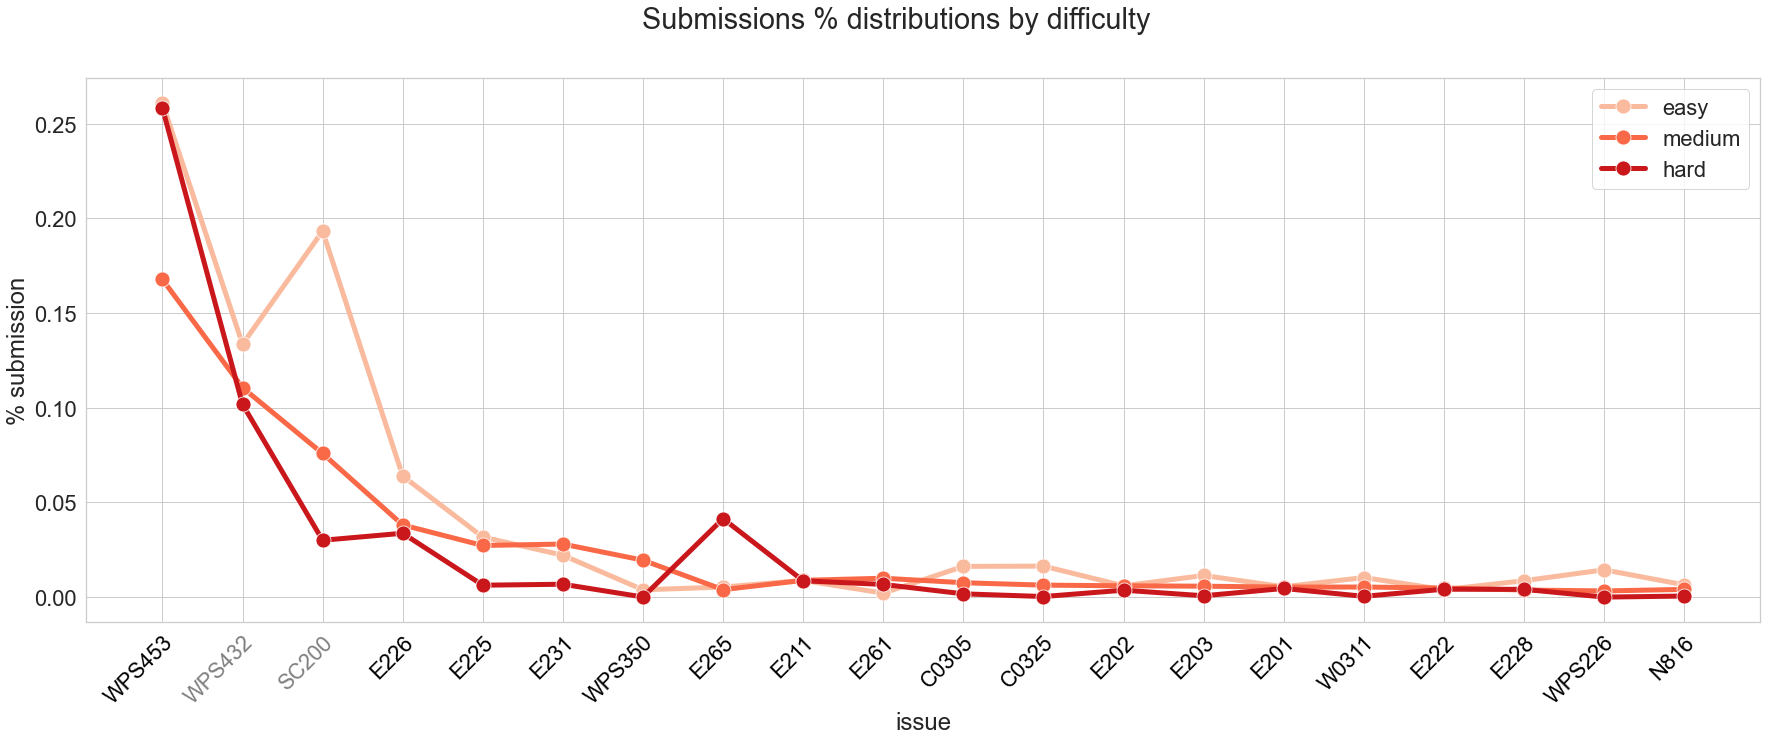

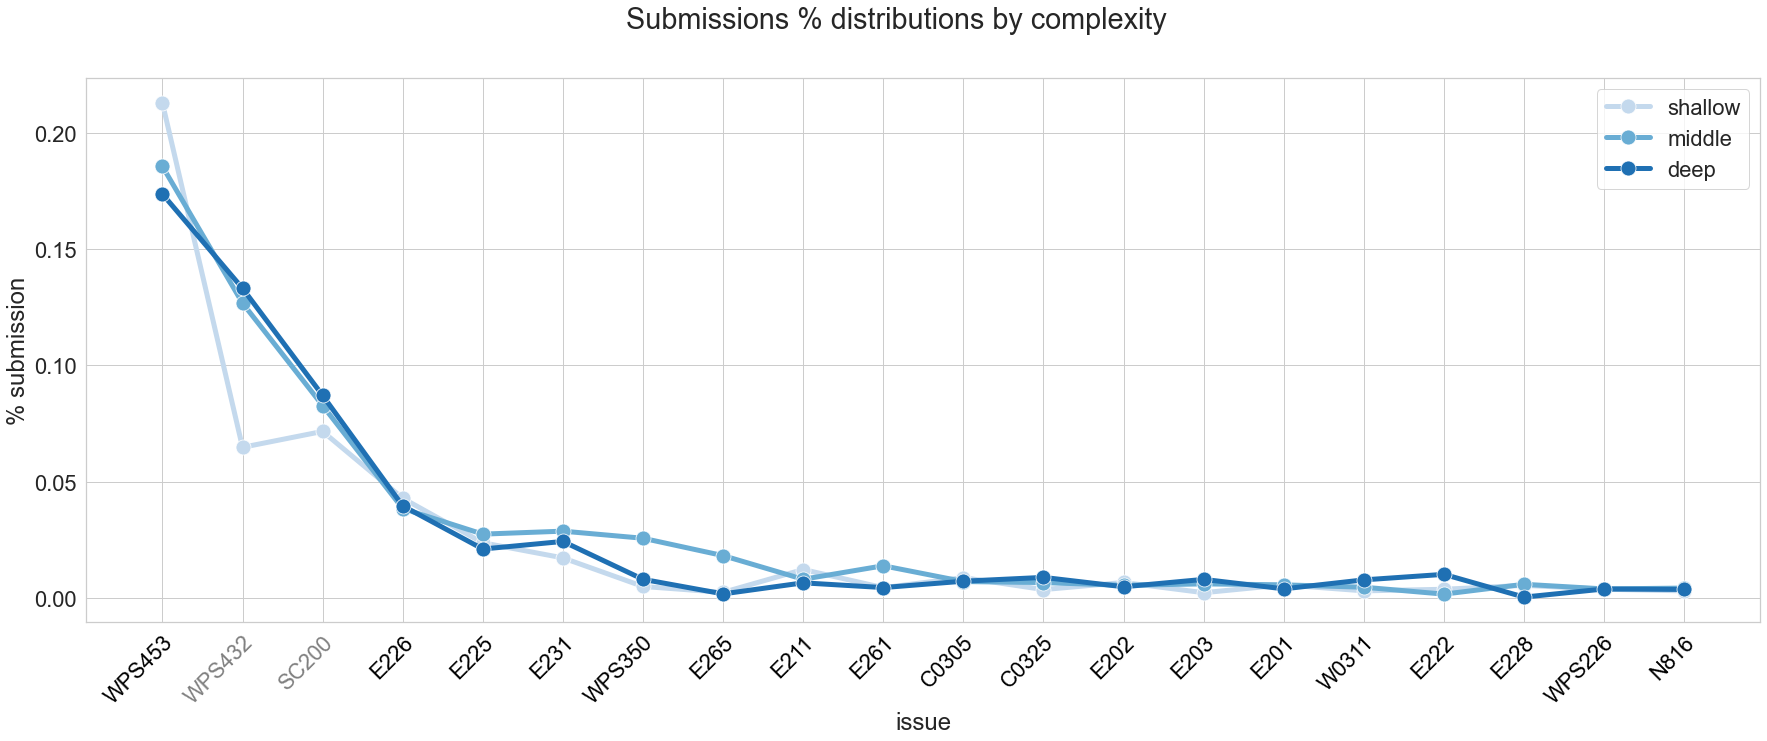

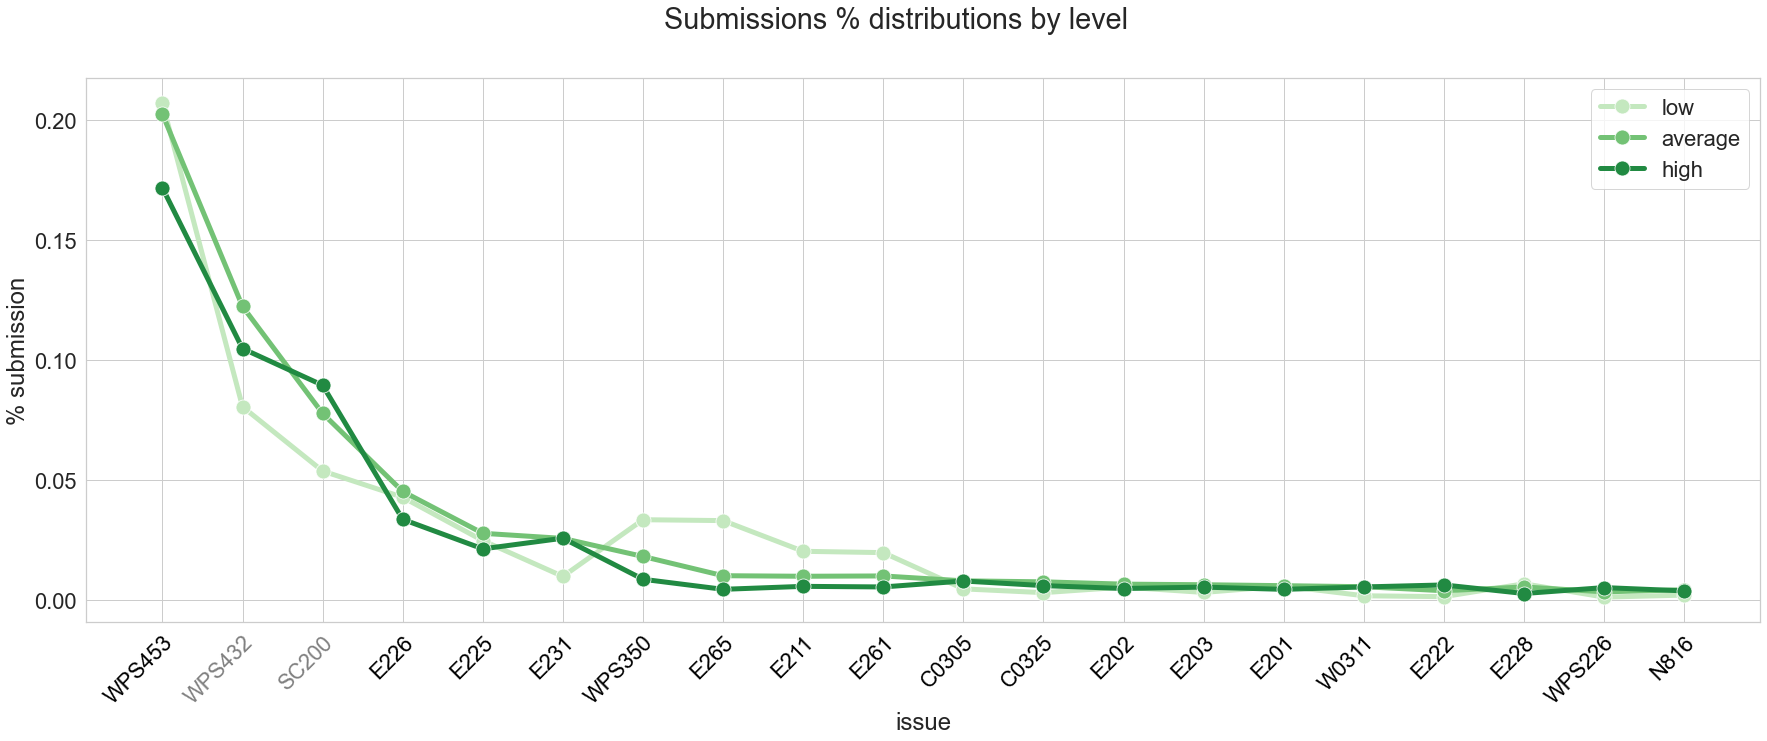

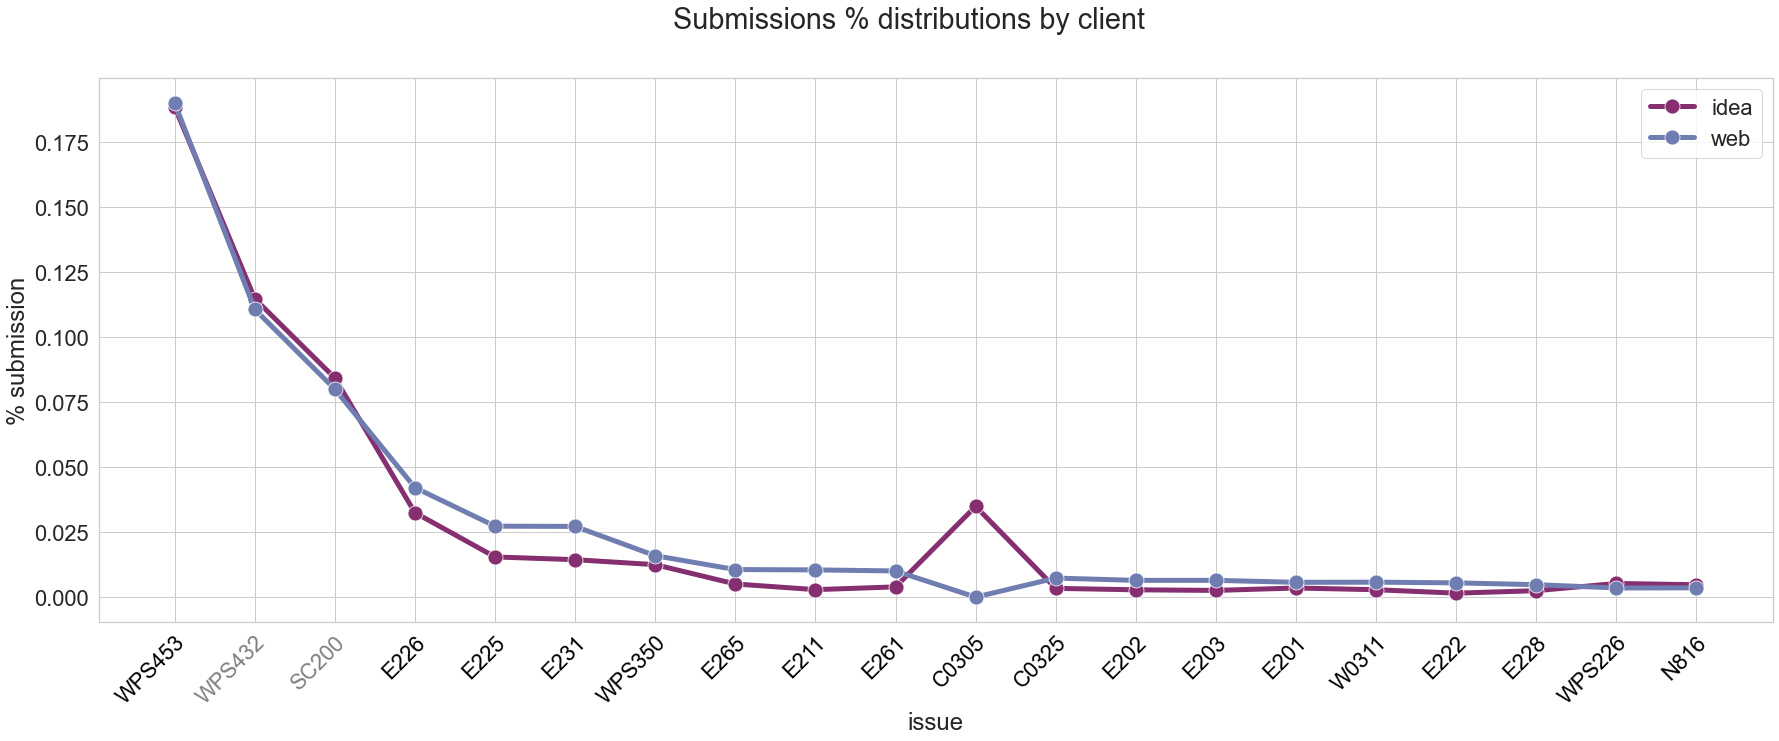

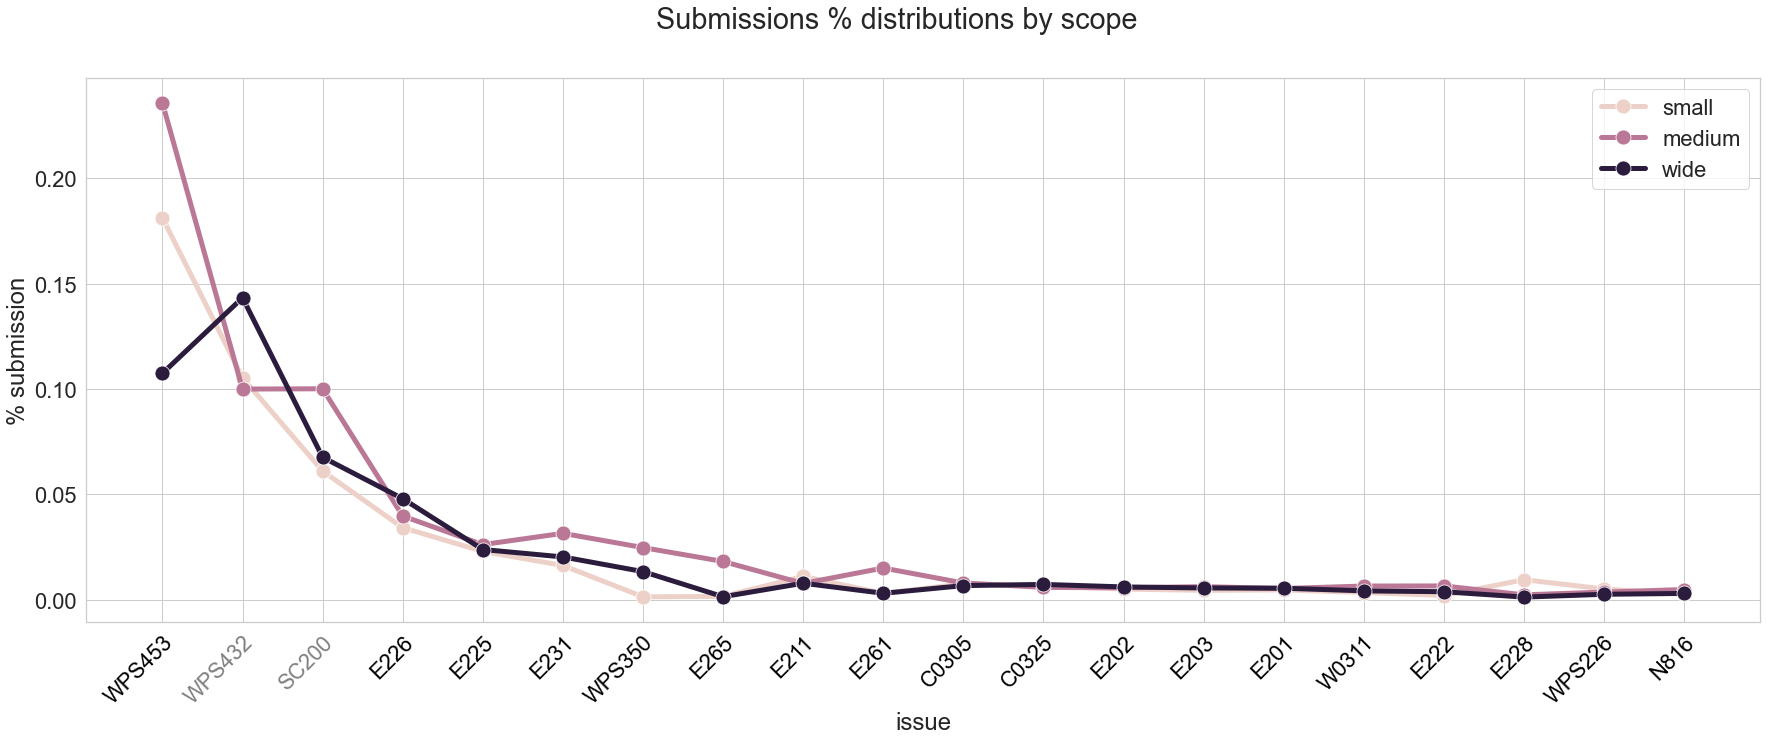

In [25]:
draw_issues(df_hyperstyle_issues_stats_unique, 
            df_hyperstyle_ignore_issues_top, 
            hyperstyle_issues_info_names,
            base_dir=os.path.join('hyperstyle', 'ignore_issues'))

### List and analysis of interesting issues (ERROR_PRONE and BEST_PRACTICES categories)
In further analysis we will consider only top 20 issues with only `ERROR_PRONE` and `BEST_PRACTICES` catecories, other issues are ignored

In [26]:
df_hyperstyle_issues_top = get_top_issues(df_hyperstyle_issues_stats_unique, 
                                          df_hyperstyle_issues, 
                                          20, 
                                          hyperstyle_issues_ignore_names)

df_hyperstyle_issues_top.to_csv(os.path.join('hyperstyle', 'issues', f'top_issues.csv'), index=False)
df_hyperstyle_issues_top

full_name        category    name  \
17      WrongMultilineStringUseViolation  BEST_PRACTICES  WPS462   
16         ExplicitStringConcatViolation  BEST_PRACTICES  WPS336   
55                 TooManyElifsViolation      COMPLEXITY  WPS223   
15          ApproximateConstantViolation  BEST_PRACTICES  WPS446   
12            LoopControlVariableNotUsed  BEST_PRACTICES    B007   
10                ShadowingPythonBuiltin     ERROR_PRONE    A001   
25                  ImplicitSumViolation  BEST_PRACTICES  WPS519   
11                     ChainedComparison  BEST_PRACTICES   R1716   
34    TooComplexFormattedStringViolation      COMPLEXITY  WPS237   
23            NegatedConditionsViolation  BEST_PRACTICES  WPS504   
13                                  H601      COMPLEXITY    H601   
33   MeaninglessNumberOperationViolation  BEST_PRACTICES  WPS345   
96            ImplicitRawStringViolation  BEST_PRACTICES  WPS342   
101               ConsiderUsingEnumerate  BEST_PRACTICES   C0200   
43         BlockAndLocalOverlapViolation     ERROR_PRONE  WPS440   
54          FloatComplexCompareViolation  BEST_PRACTICES  WPS459   
14                    RedefinedOuterName  BEST_PRACTICES   W0621   
88            UselessLenCompareViolation  BEST_PRACTICES  WPS507   
61                                 E0602     ERROR_PRONE   E0602   
65                    TooComplexFunction      COMPLEXITY    C901   

                                                  link  count     ratio  
17   https://wemake-python-styleguide.readthedocs.i...   3531  0.025425  
16   https://wemake-python-styleguide.readthedocs.i...   3177  0.022876  
55   https://wemake-python-styleguide.readthedocs.i...   1824  0.013134  
15   https://wemake-python-styleguide.readthedocs.i...   1528  0.011003  
12   https://github.com/PyCQA/flake8-bugbear#list-o...   1445  0.010405  
10           https://pypi.org/project/flake8-builtins/   1248  0.008986  
25   https://wemake-python-styleguide.readthedocs.i...   1188  0.008554  
11   https://vald-phoenix.github.io/pylint-errors/p...   1049  0.007553  
34   https://wemake-python-styleguide.readthedocs.i...   1024  0.007373  
23   https://wemake-python-styleguide.readthedocs.i...    771  0.005552  
13                                                 NaN    740  0.005328  
33   https://wemake-python-styleguide.readthedocs.i...    729  0.005249  
96   https://wemake-python-styleguide.readthedocs.i...    704  0.005069  
101  https://vald-phoenix.github.io/pylint-errors/p...    674  0.004853  
43   https://wemake-python-styleguide.readthedocs.i...    671  0.004832  
54   https://wemake-python-styleguide.readthedocs.i...    671  0.004832  
14   https://vald-phoenix.github.io/pylint-errors/p...    572  0.004119  
88   https://wemake-python-styleguide.readthedocs.i...    550  0.003960  
61                                                 NaN    507  0.003651  
65         https://www.flake8rules.com/rules/C901.html    457  0.003291

### Percent of all submissions which contain each hyperstyle issue

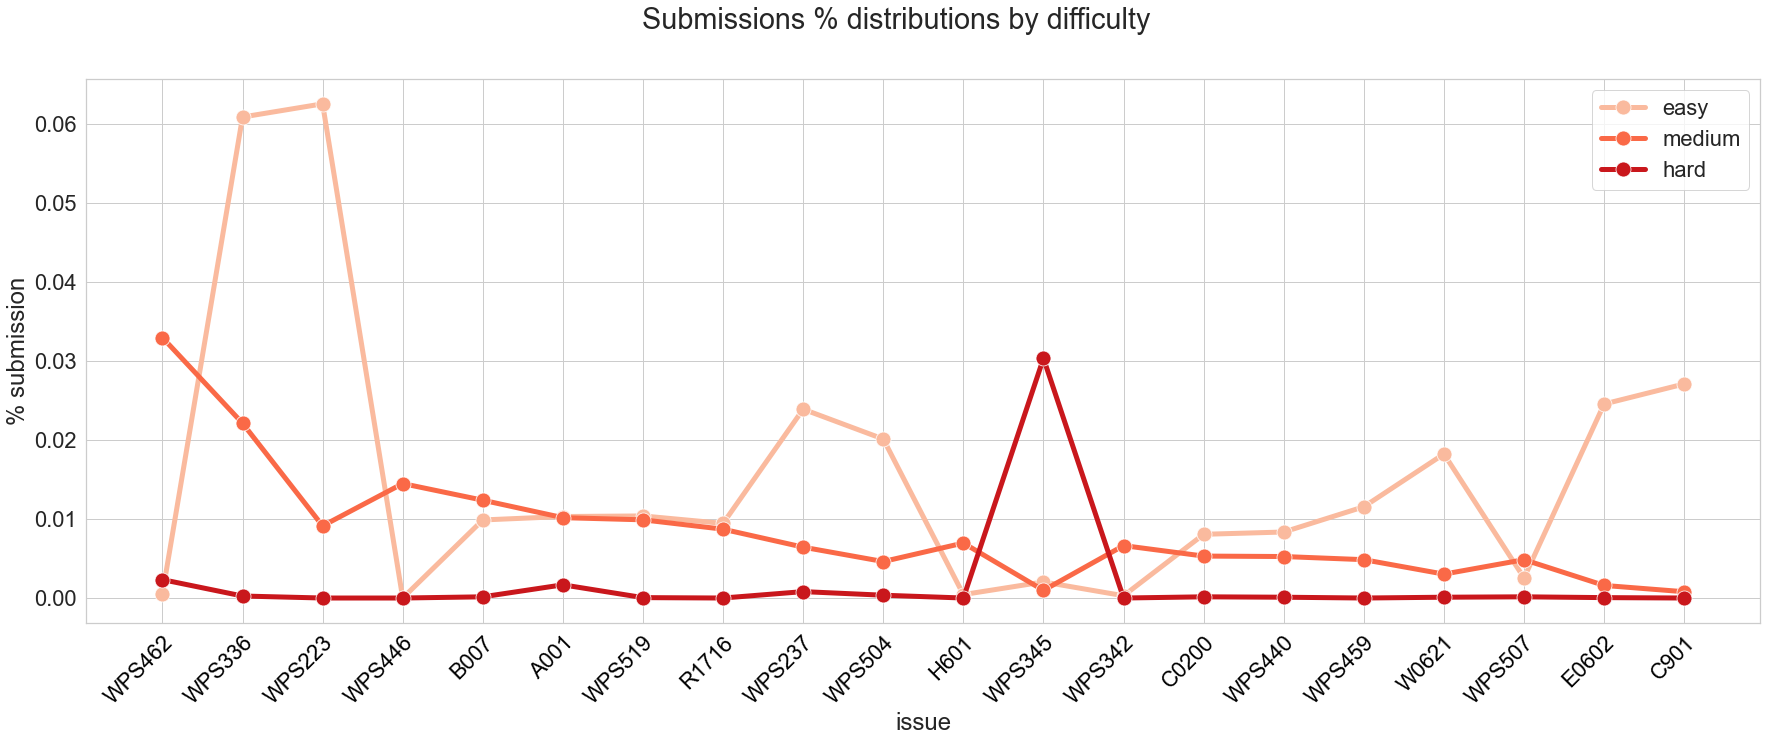

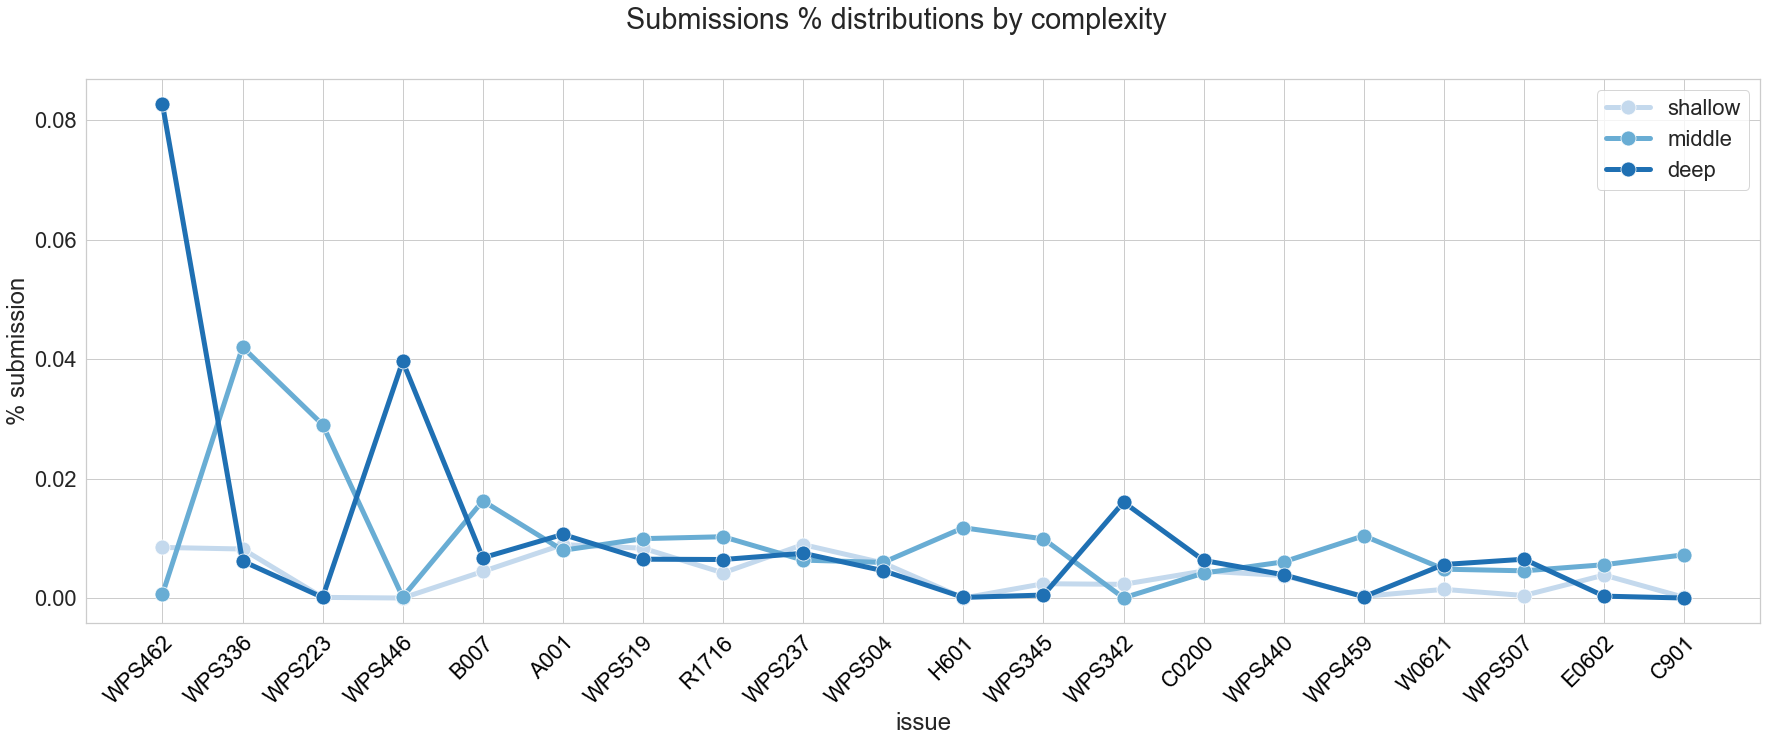

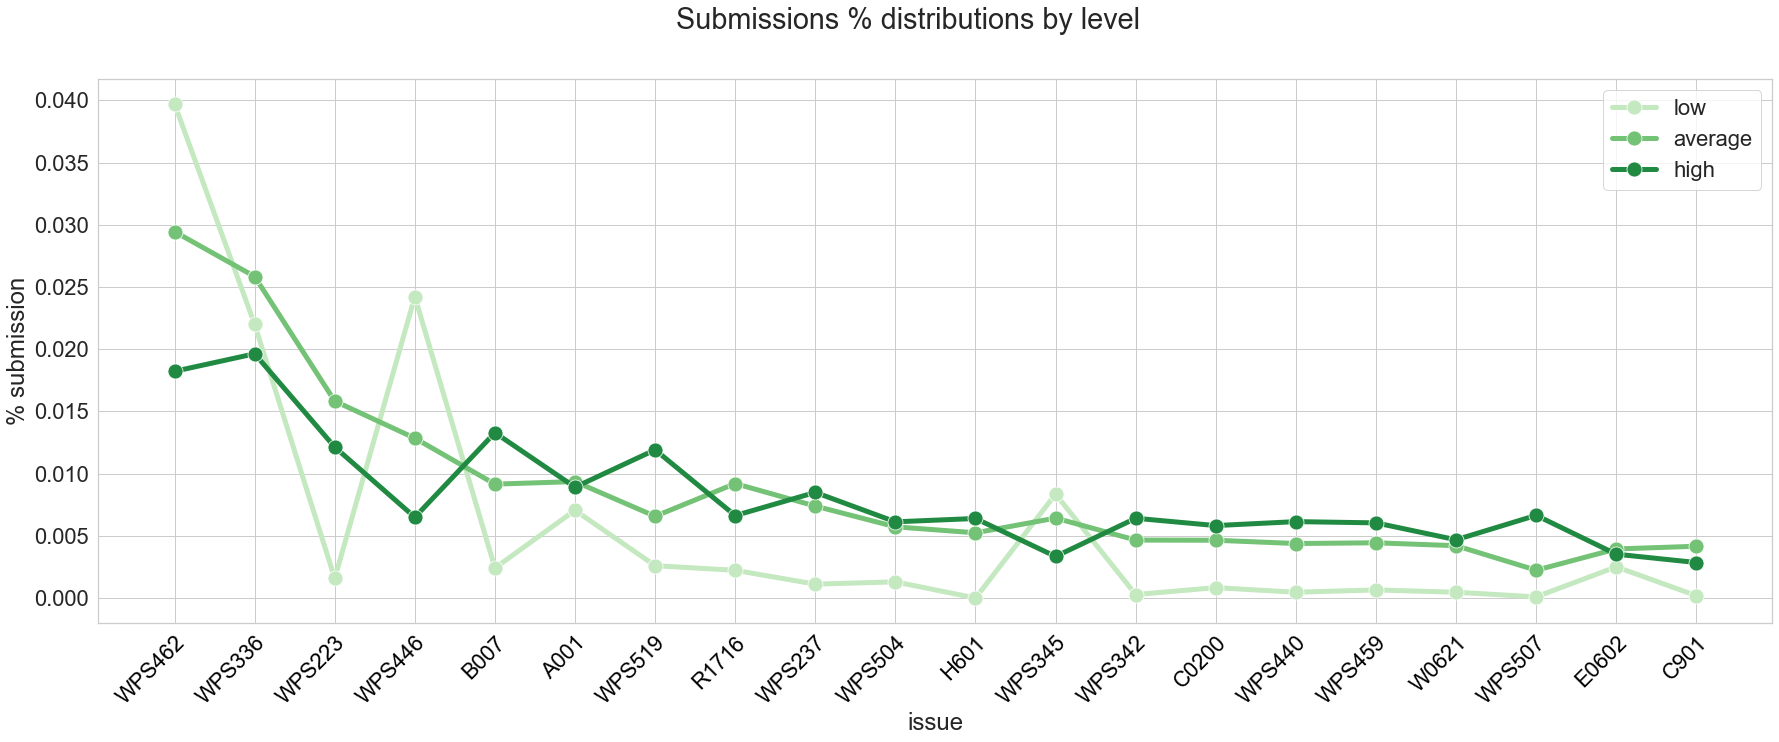

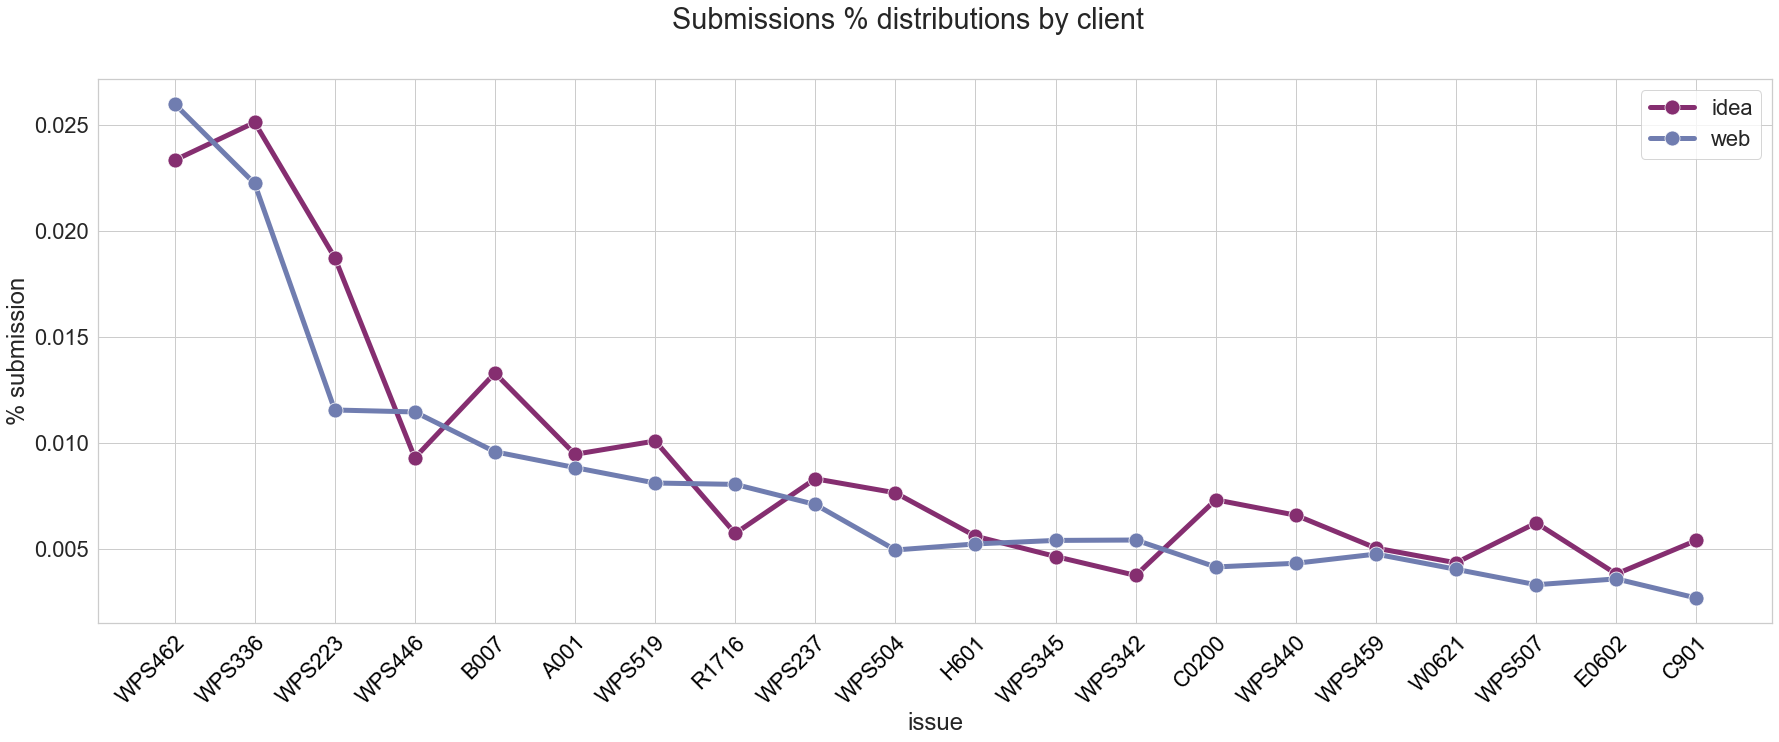

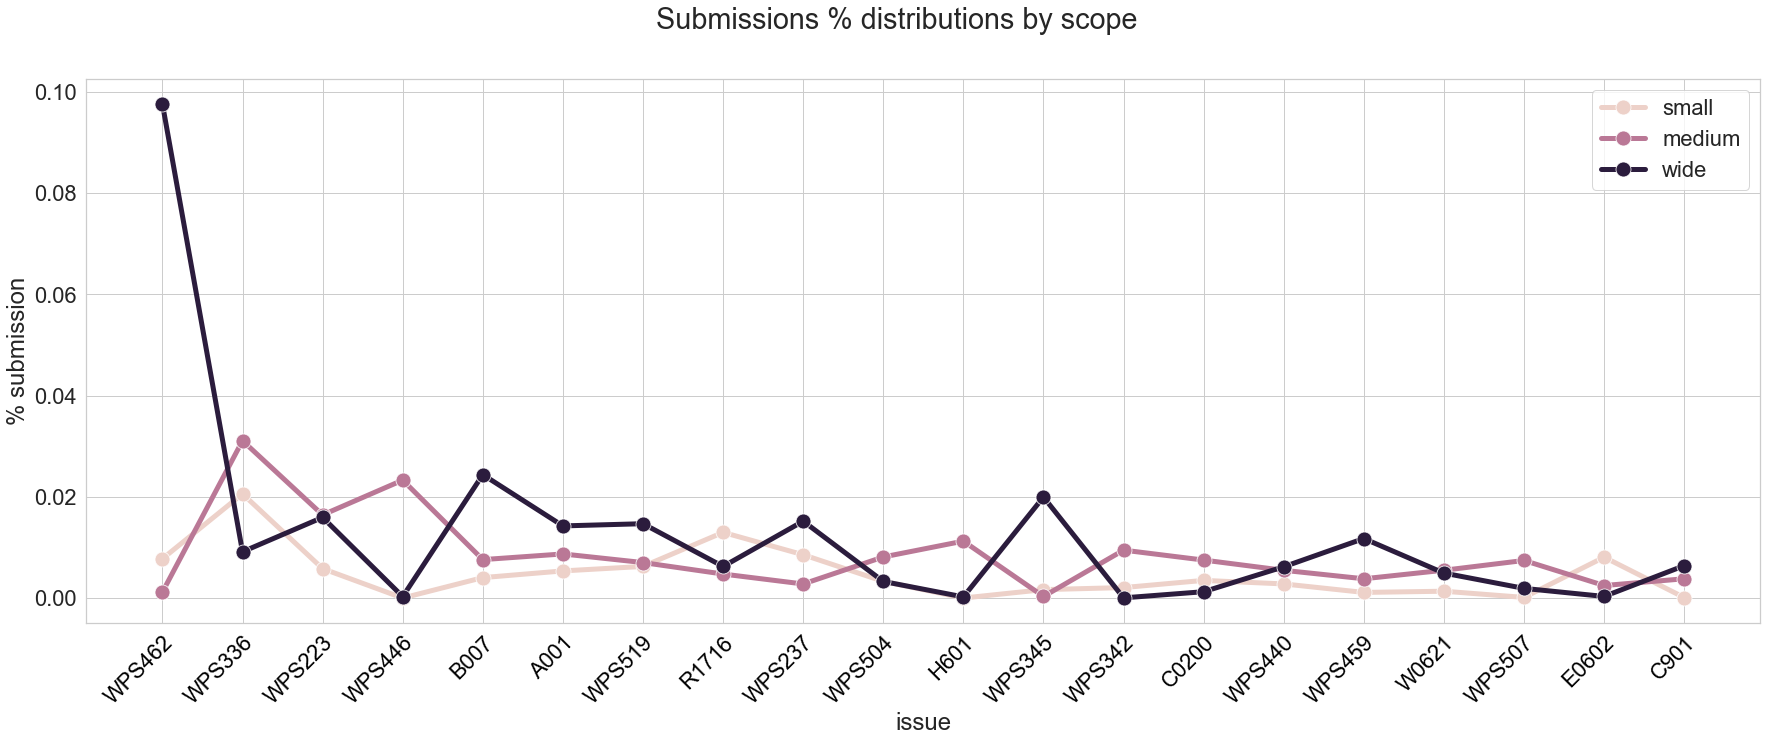

In [64]:
draw_issues(df_hyperstyle_issues_stats_unique, 
            df_hyperstyle_issues_top, 
            hyperstyle_issues_info_names,
            base_dir=os.path.join('hyperstyle', 'issues'))

# First attempt stats
First attempt submissions is when **attempt** == 1. This is the most interesting case as student do not see code quality feedback before so 1-st attempt shows the exact level of sudent code quality without any hints.

In [65]:
df_first_attempt_stats = df_submissions_stats[df_submissions_stats['attempt'] == 1]
df_first_attempt_stats.describe()

id  code_lines_count  code_symbols_count  \
count  1.203330e+05     120333.000000       120333.000000   
mean   4.268681e+07          6.513508          125.952465   
std    7.710392e+06          4.527973          122.046511   
min    2.938330e+07          1.000000            8.000000   
25%    3.575652e+07          3.000000           47.000000   
50%    4.272384e+07          5.000000           90.000000   
75%    4.952578e+07          8.000000          163.000000   
max    5.639708e+07         89.000000         3264.000000   

       hyperstyle_issues_count  hyperstyle_issues_by_code_lines  \
count            120333.000000                    120333.000000   
mean                  1.455860                         0.230913   
std                   5.478438                         1.442586   
min                   0.000000                         0.000000   
25%                   0.000000                         0.000000   
50%                   1.000000                         0.090909   
75%                   2.000000                         0.272727   
max                 443.000000                       210.000000   

             step_id   sync_counter        user_id         group   attempt  \
count  120333.000000  120333.000000  120333.000000  1.203330e+05  120333.0   
mean     7336.477350       4.804601   14570.554212  1.055683e+05       1.0   
std      1640.215482       1.023397   11866.230563  8.198010e+04       0.0   
min      5205.000000       2.000000       3.000000  2.000000e+00       1.0   
25%      6382.000000       4.000000    4186.000000  5.234900e+04       1.0   
50%      6812.000000       5.000000   12156.000000  1.038630e+05       1.0   
75%      8212.000000       5.000000   21566.000000  1.532290e+05       1.0   
max     15188.000000      19.000000   82097.000000  1.722213e+06       1.0   

       total_attempts  
count   120333.000000  
mean         1.154106  
std          0.480379  
min          1.000000  
25%          1.000000  
50%          1.000000  
75%          1.000000  
max          5.000000

### First attempt statistics

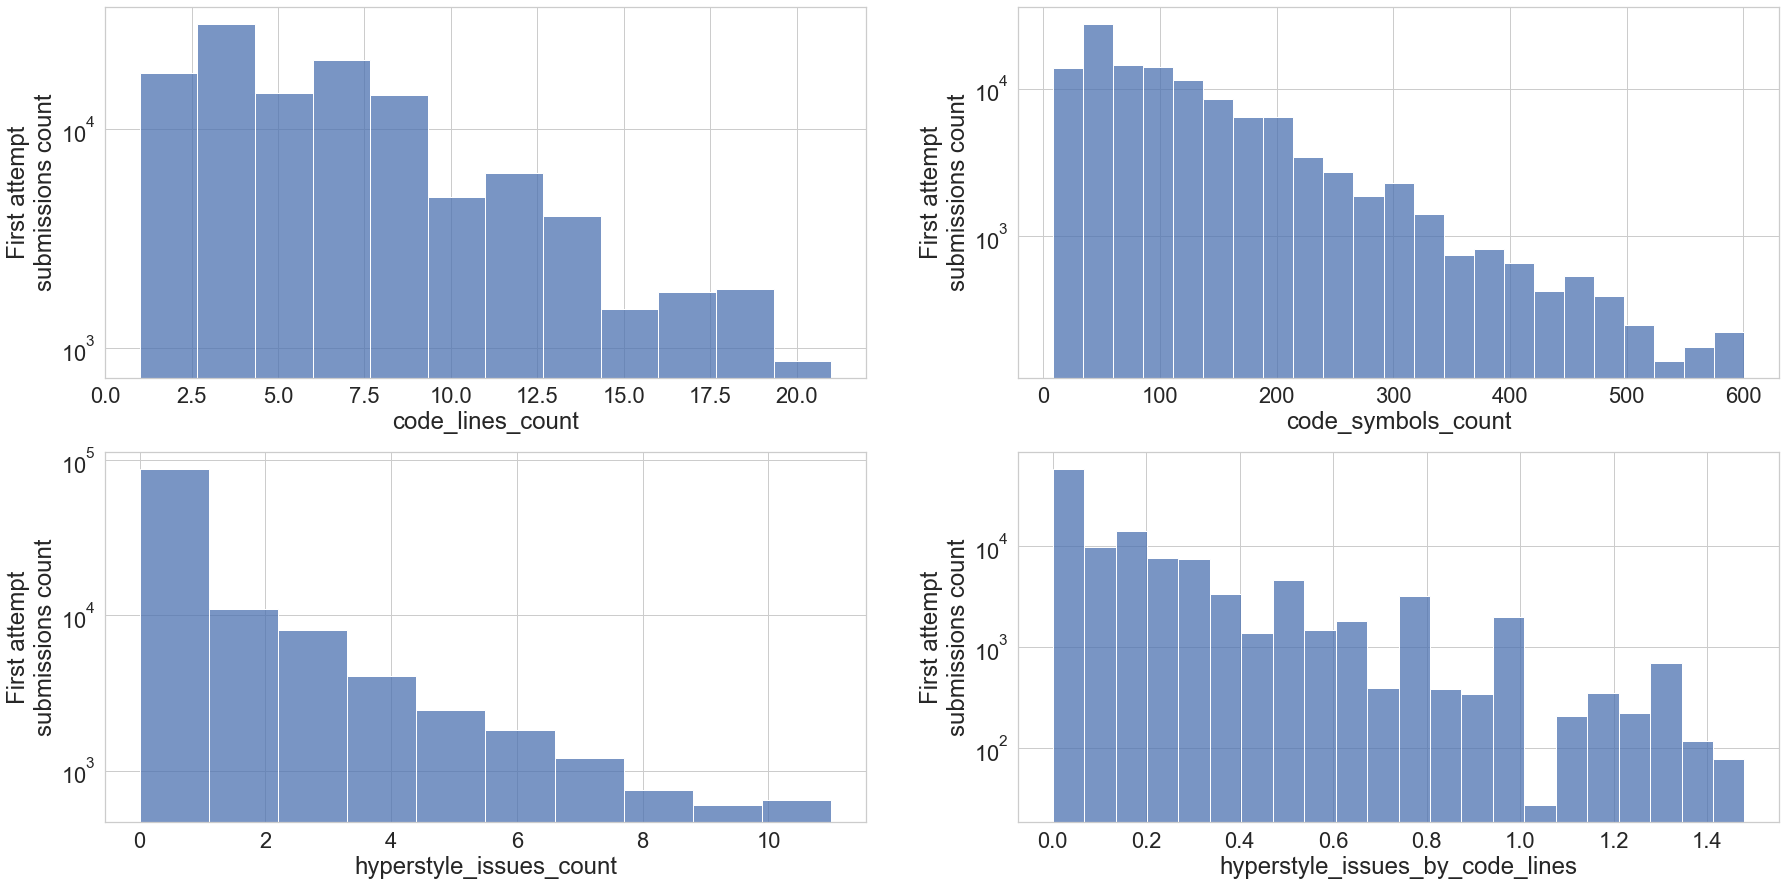

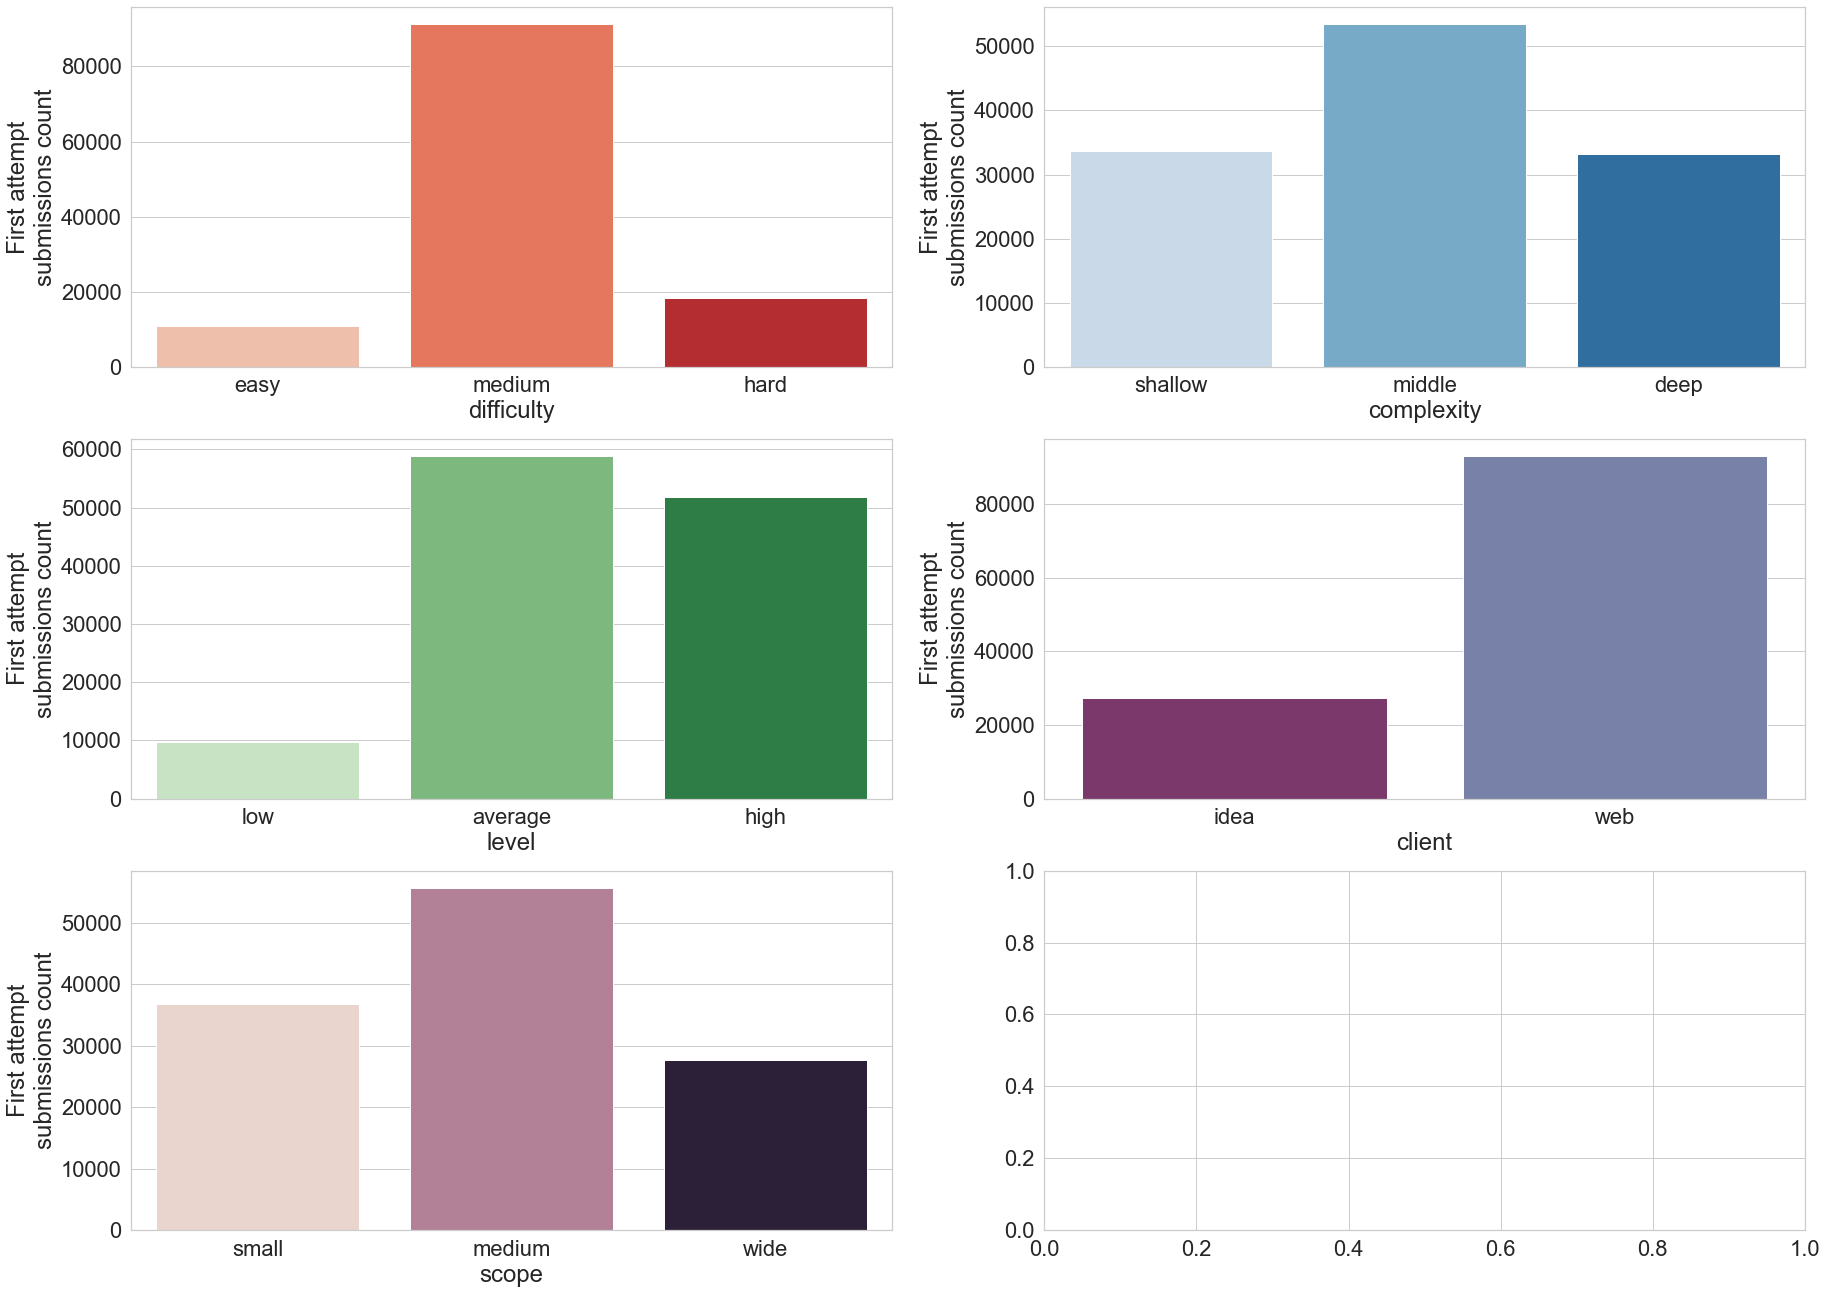

In [66]:
draw_hist_plots(df_first_attempt_stats, ['code_lines_count', 'code_symbols_count', 
                                       'hyperstyle_issues_count', 'hyperstyle_issues_by_code_lines'], 
                log_scale=(False, True), y_label='First attempt\nsubmissions count')

draw_count_plots(df_first_attempt_stats, ['difficulty', 'complexity', 'level', 'client', 'scope'], 
                 y_label='First attempt\nsubmissions count')

In [67]:
df_first_attempt_hyperstyle_issues_stats = \
    merge_dfs(df_first_attempt_stats, df_hyperstyle_issues_stats, left_on='id', right_on='id')
df_first_attempt_hyperstyle_issues_stats_unique = \
    merge_dfs(df_first_attempt_stats, df_hyperstyle_issues_stats_unique, left_on='id', right_on='id')


### Hyperstyle issues analysis in first attempt. Percent of submissions with each issue.

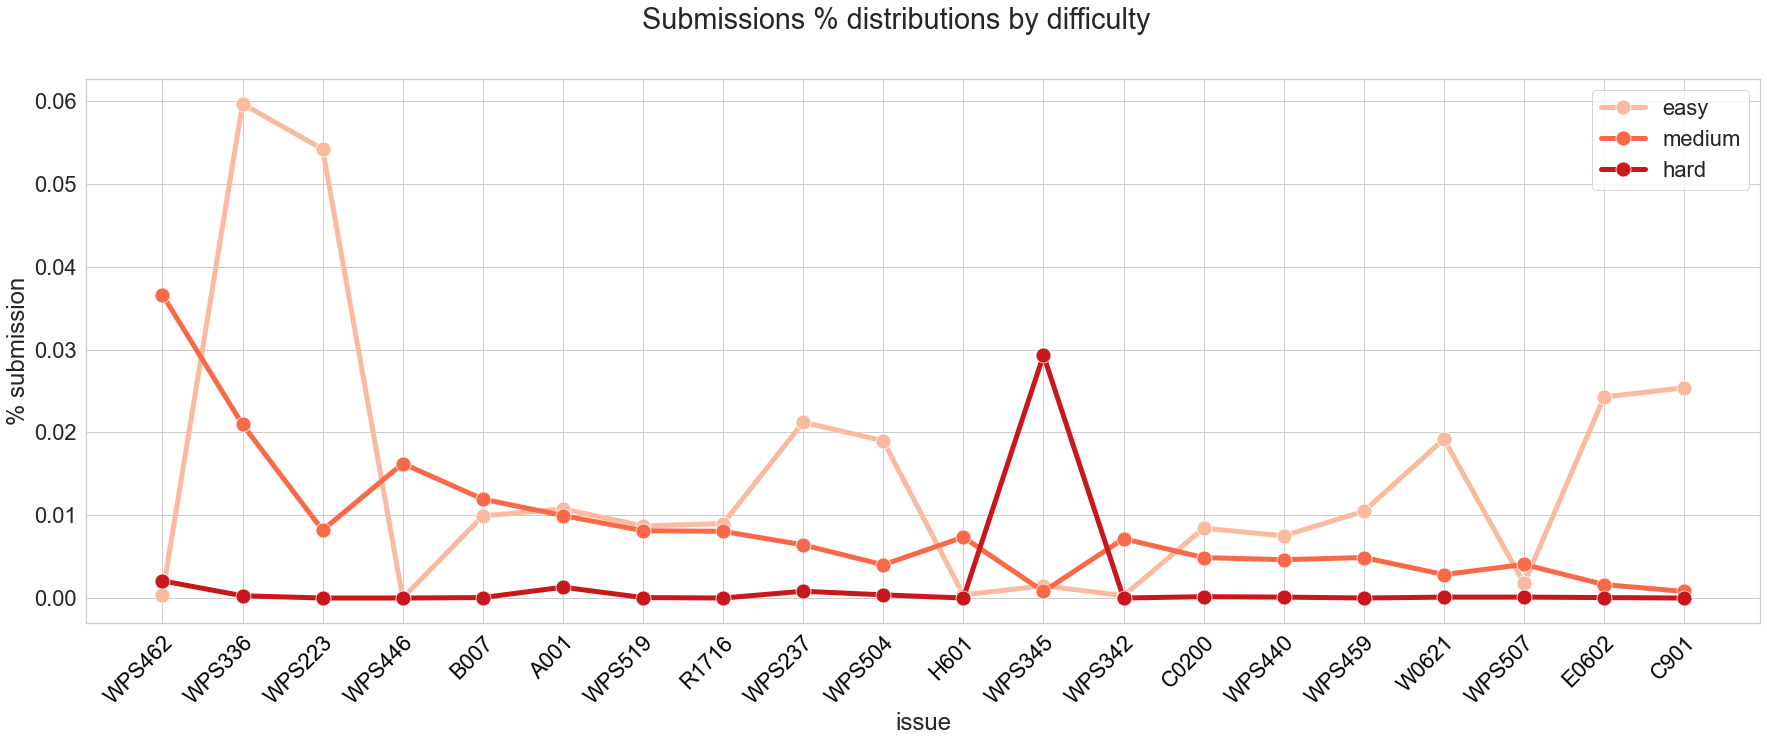

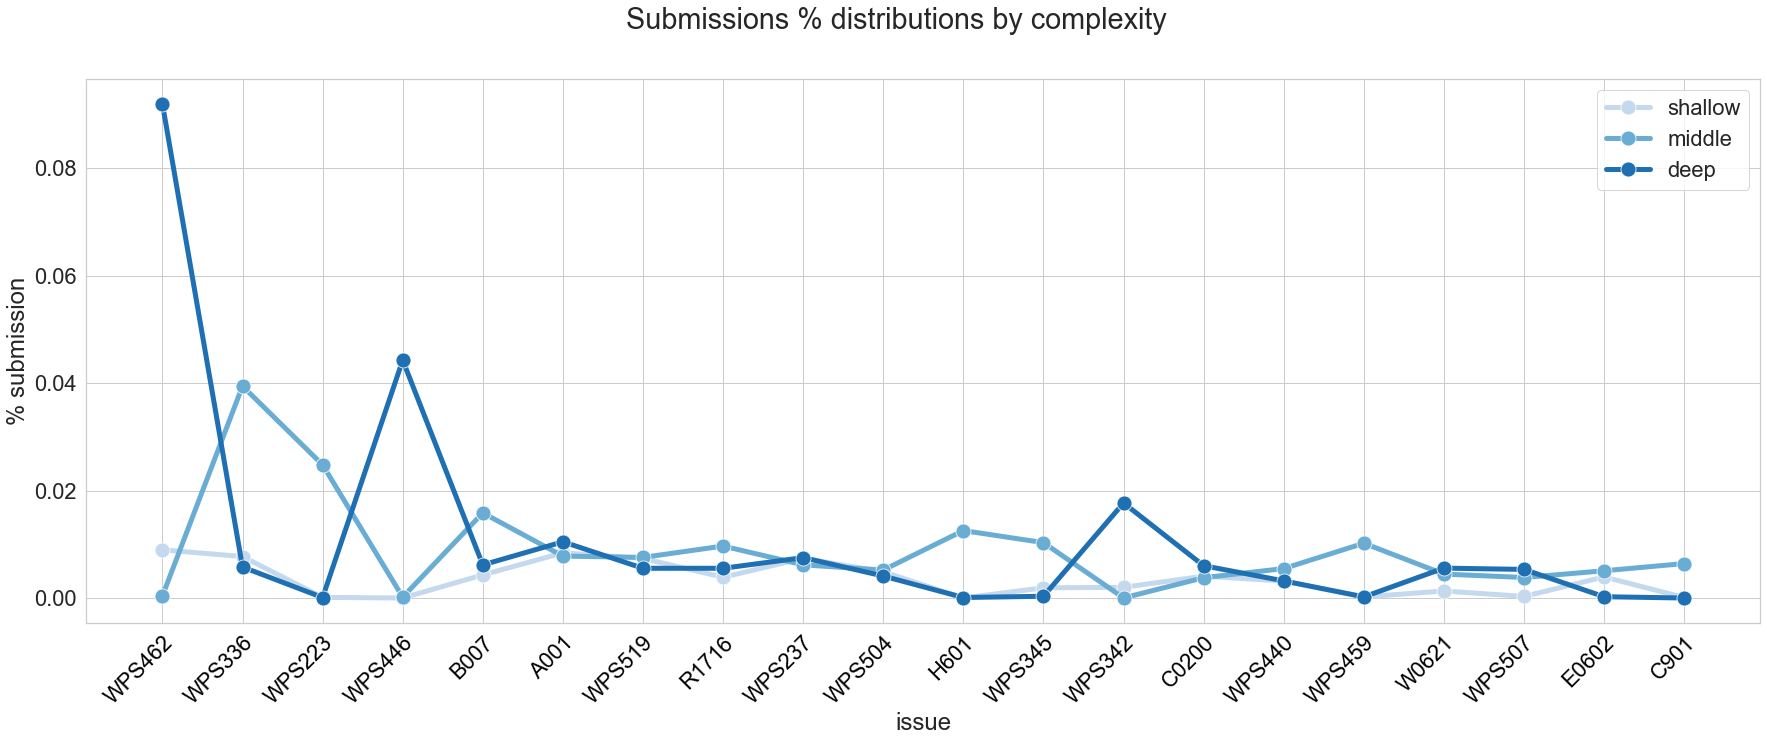

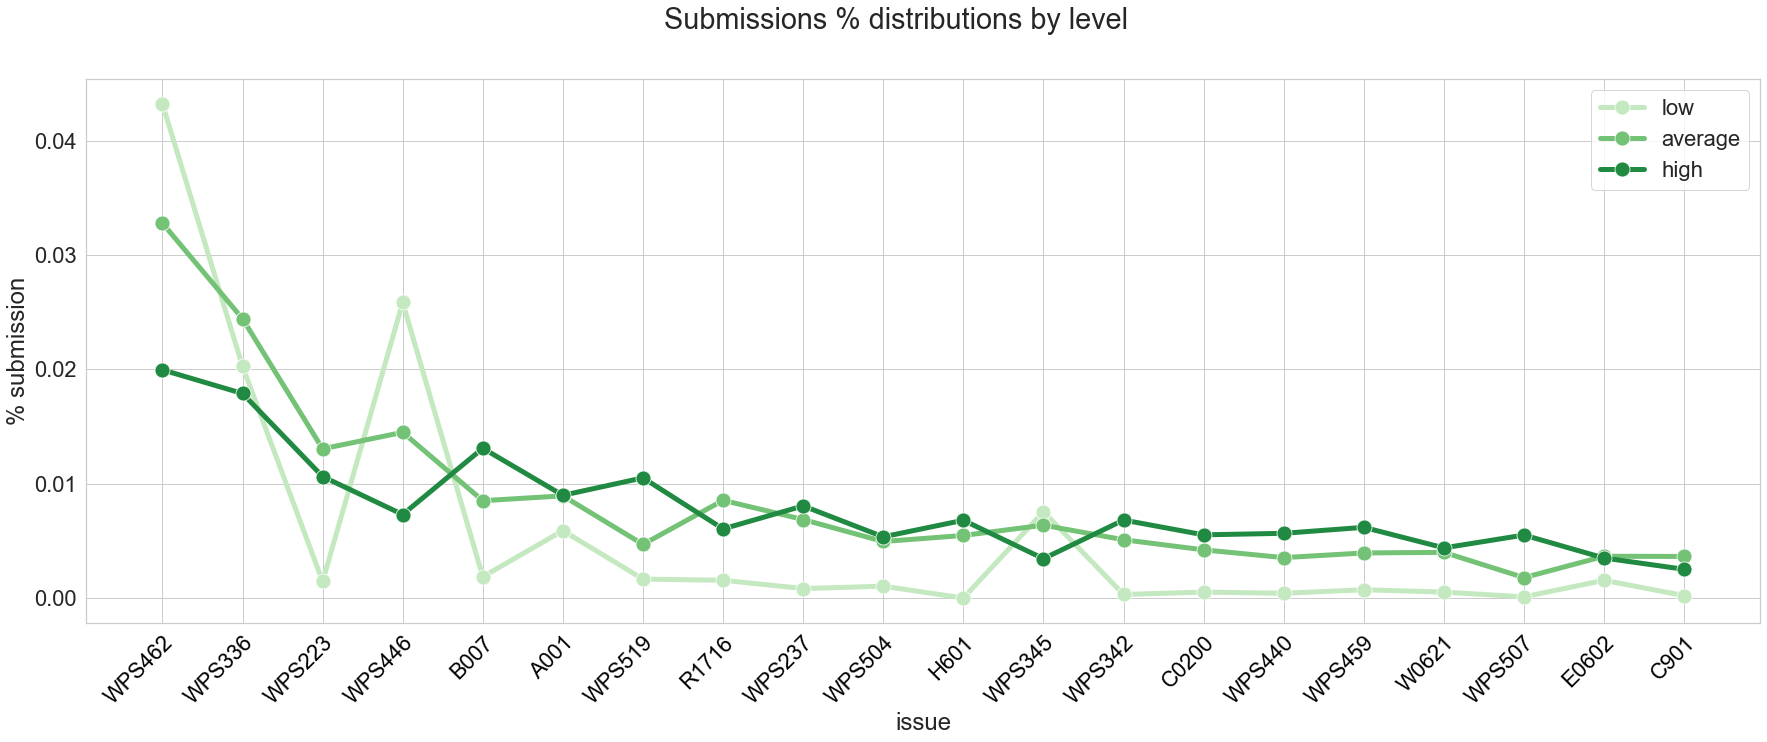

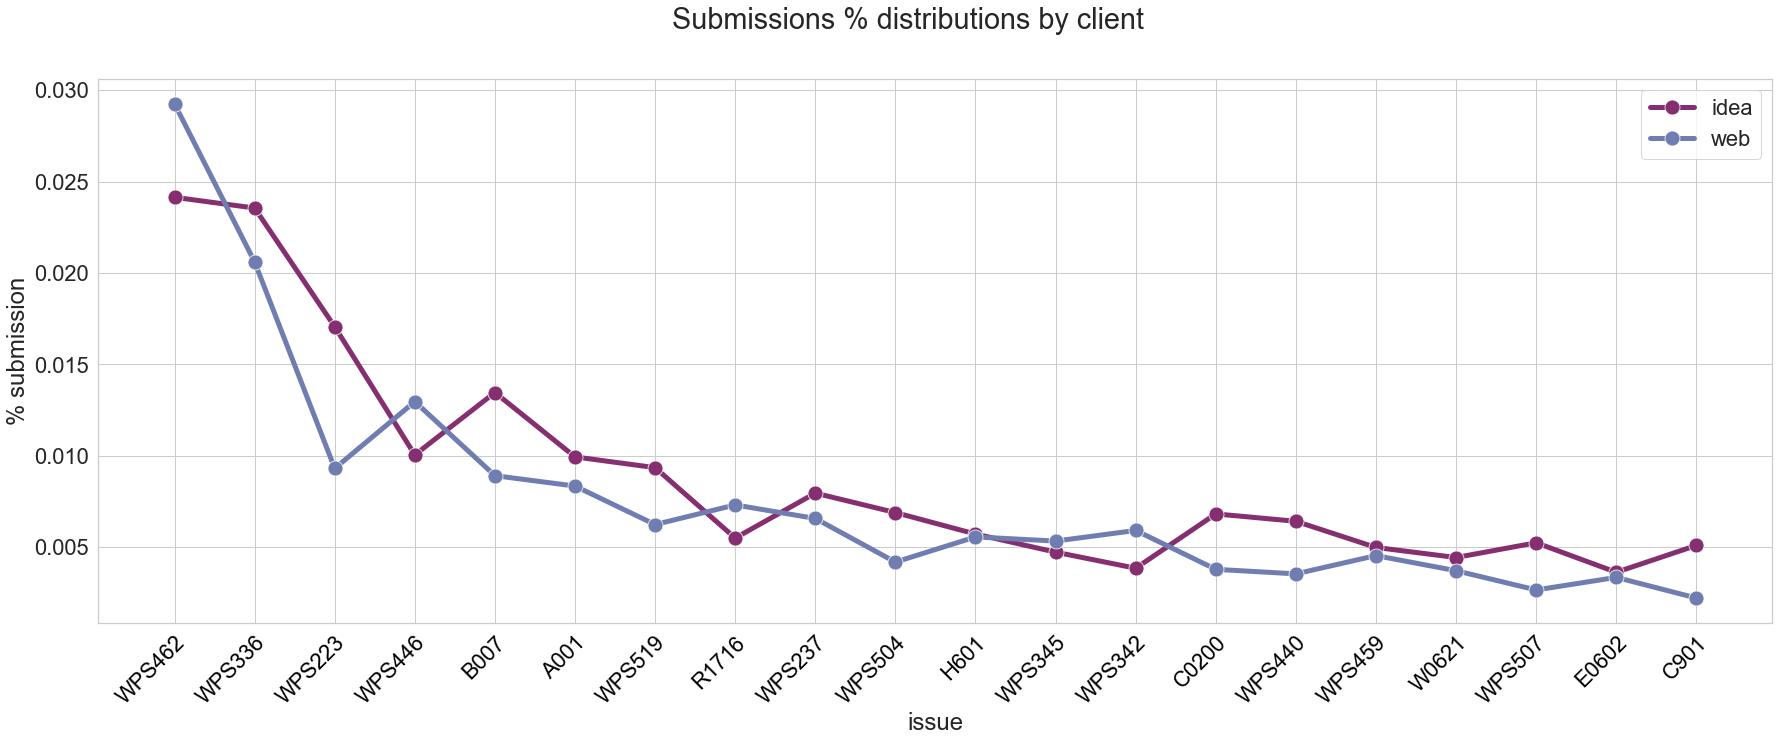

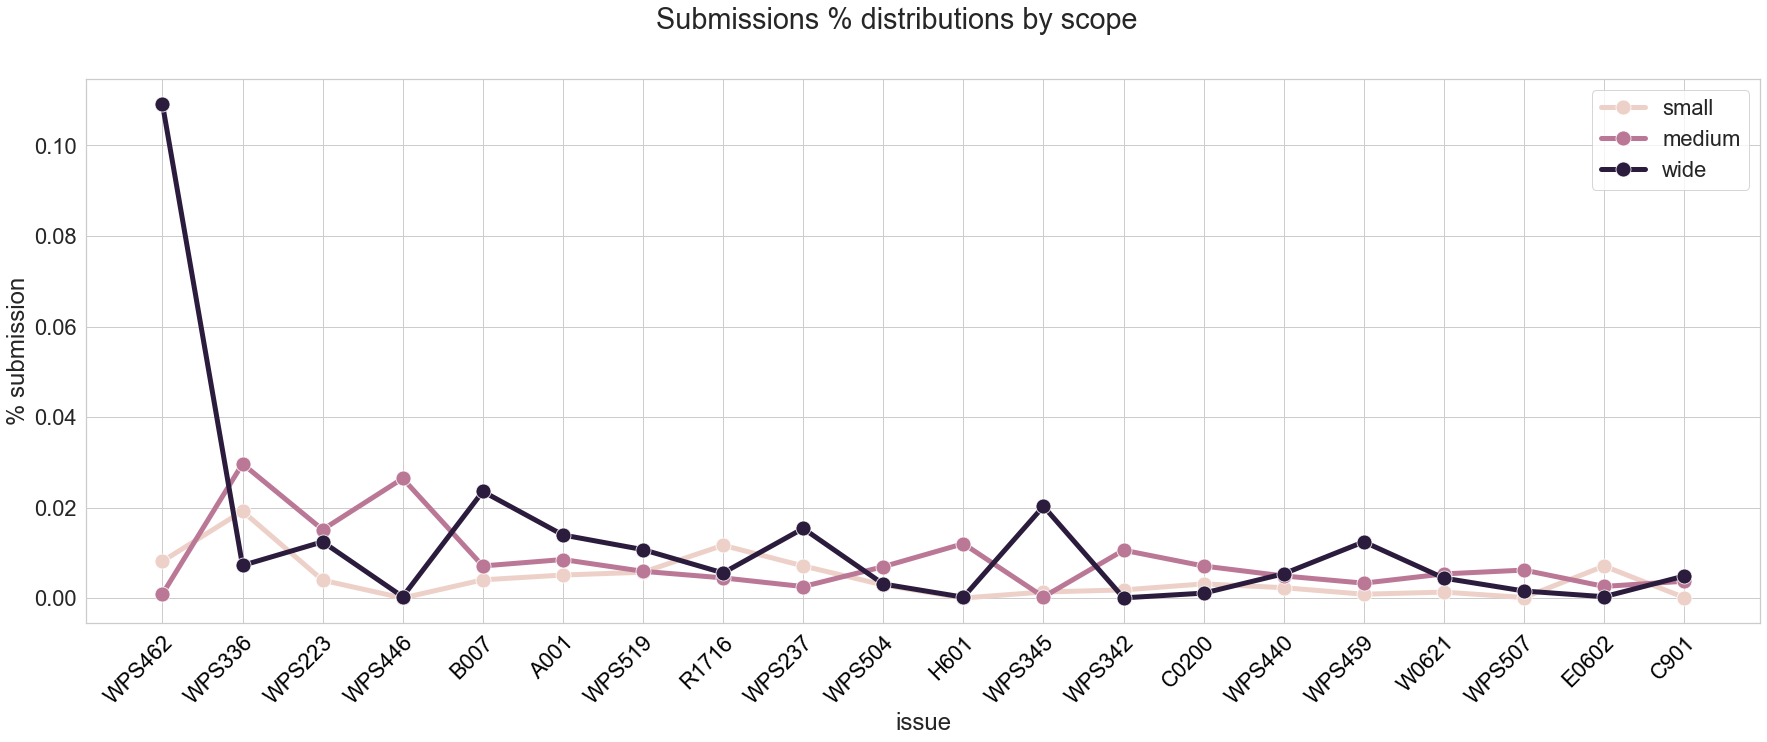

In [68]:
draw_issues(df_first_attempt_hyperstyle_issues_stats_unique, 
            df_hyperstyle_issues_top, 
            hyperstyle_issues_info_names,
            base_dir=os.path.join('hyperstyle', 'issues_first_attempt'))

## Stat tests

In [69]:
importlib.reload(analysis.src.python.data_analysis.stat_test.iticse_2022.rq_stat_tests)

from analysis.src.python.data_analysis.stat_test.iticse_2022.rq_stat_tests import run_stat_tests

run_stat_tests(df_first_attempt_hyperstyle_issues_stats_unique, 
               df_hyperstyle_issues_top['name'].values,
               ['rq1'])

######################RQ1######################
H0: The task's difficulty and code quality issue's type not influence on the percentage of submissions with code quality issues

######################ISSUE TYPE: WPS462######################
       Source  ddof1   ddof2           F          p-unc       np2
0  difficulty      2  120330  504.739548  5.114166e-219  0.008319


######################ISSUE TYPE: WPS336######################
       Source  ddof1   ddof2           F          p-unc       np2
0  difficulty      2  120330  582.056849  2.696825e-252  0.009582


######################ISSUE TYPE: WPS223######################
       Source  ddof1   ddof2            F  p-unc       np2
0  difficulty      2  120330  1072.952355    0.0  0.017521


######################ISSUE TYPE: WPS446######################
       Source  ddof1   ddof2           F          p-unc       np2
0  difficulty      2  120330  240.499265  5.763643e-105  0.003981


######################ISSUE TYPE: B007###########

  Source  ddof1   ddof2           F          p-unc       np2
0  scope      2  120330  230.857937  8.541507e-101  0.003822


######################ISSUE TYPE: WPS223######################
  Source  ddof1   ddof2           F         p-unc       np2
0  scope      2  120330  129.664409  5.598302e-57  0.002151


######################ISSUE TYPE: WPS446######################
  Source  ddof1   ddof2           F  p-unc       np2
0  scope      2  120330  863.838594    0.0  0.014155


######################ISSUE TYPE: B007######################
  Source  ddof1   ddof2           F          p-unc       np2
0  scope      2  120330  351.717384  4.963917e-153  0.005812


######################ISSUE TYPE: A001######################
  Source  ddof1   ddof2          F         p-unc     np2
0  scope      2  120330  72.258747  4.337650e-32  0.0012


######################ISSUE TYPE: WPS519######################
  Source  ddof1   ddof2          F         p-unc       np2
0  scope      2  120330  36.814516  

   Source  ddof1   ddof2          F    p-unc       np2
0  client      1  120331  10.103291  0.00148  0.000084


######################ISSUE TYPE: WPS237######################
   Source  ddof1   ddof2         F     p-unc       np2
0  client      1  120331  5.925531  0.014924  0.000049


######################ISSUE TYPE: WPS504######################
   Source  ddof1   ddof2          F         p-unc       np2
0  client      1  120331  32.343992  1.294541e-08  0.000269


######################ISSUE TYPE: H601######################
   Source  ddof1   ddof2         F     p-unc           np2
0  client      1  120331  0.095082  0.757813  7.901729e-07


######################ISSUE TYPE: WPS345######################
   Source  ddof1   ddof2        F     p-unc       np2
0  client      1  120331  1.49861  0.220888  0.000012


######################ISSUE TYPE: WPS342######################
   Source  ddof1   ddof2          F     p-unc       np2
0  client      1  120331  16.619092  0.000046  0.000138

# Last attempt stats

Last attempt submissions is when **attempt** == **total_attemps** - final result of all attemps. This shows what issues student do not fix and leave in their final solutions.

In [70]:
df_last_attempt_stats = df_submissions_stats[df_submissions_stats['attempt'] == df_submissions_stats['total_attempts']]
df_last_attempt_stats.describe()

id  code_lines_count  code_symbols_count  \
count  1.203330e+05     120333.000000       120333.000000   
mean   4.269663e+07          6.467727          125.117424   
std    7.710513e+06          4.481627          120.833349   
min    2.938330e+07          1.000000            8.000000   
25%    3.577425e+07          3.000000           48.000000   
50%    4.273895e+07          5.000000           90.000000   
75%    4.954060e+07          8.000000          162.000000   
max    5.639711e+07         89.000000         3264.000000   

       hyperstyle_issues_count  hyperstyle_issues_by_code_lines  \
count            120333.000000                    120333.000000   
mean                  1.283123                         0.205632   
std                   5.766171                         1.554333   
min                   0.000000                         0.000000   
25%                   0.000000                         0.000000   
50%                   0.000000                         0.000000   
75%                   1.000000                         0.250000   
max                 443.000000                       210.000000   

             step_id   sync_counter        user_id         group  \
count  120333.000000  120333.000000  120333.000000  1.203330e+05   
mean     7336.477350       4.805332   14570.554212  1.055683e+05   
std      1640.215482       1.022594   11866.230563  8.198010e+04   
min      5205.000000       2.000000       3.000000  2.000000e+00   
25%      6382.000000       4.000000    4186.000000  5.234900e+04   
50%      6812.000000       5.000000   12156.000000  1.038630e+05   
75%      8212.000000       5.000000   21566.000000  1.532290e+05   
max     15188.000000      19.000000   82097.000000  1.722213e+06   

             attempt  total_attempts  
count  120333.000000   120333.000000  
mean        1.154106        1.154106  
std         0.480379        0.480379  
min         1.000000        1.000000  
25%         1.000000        1.000000  
50%         1.000000        1.000000  
75%         1.000000        1.000000  
max         5.000000        5.000000

### Last attempt statistics

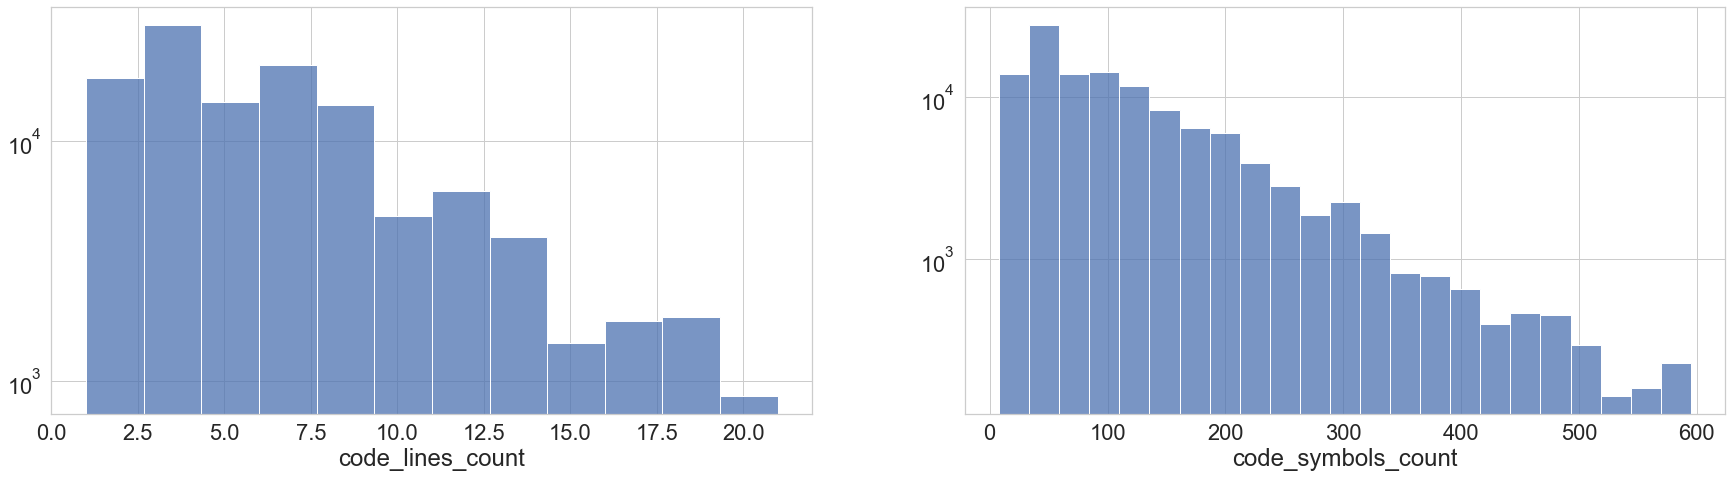

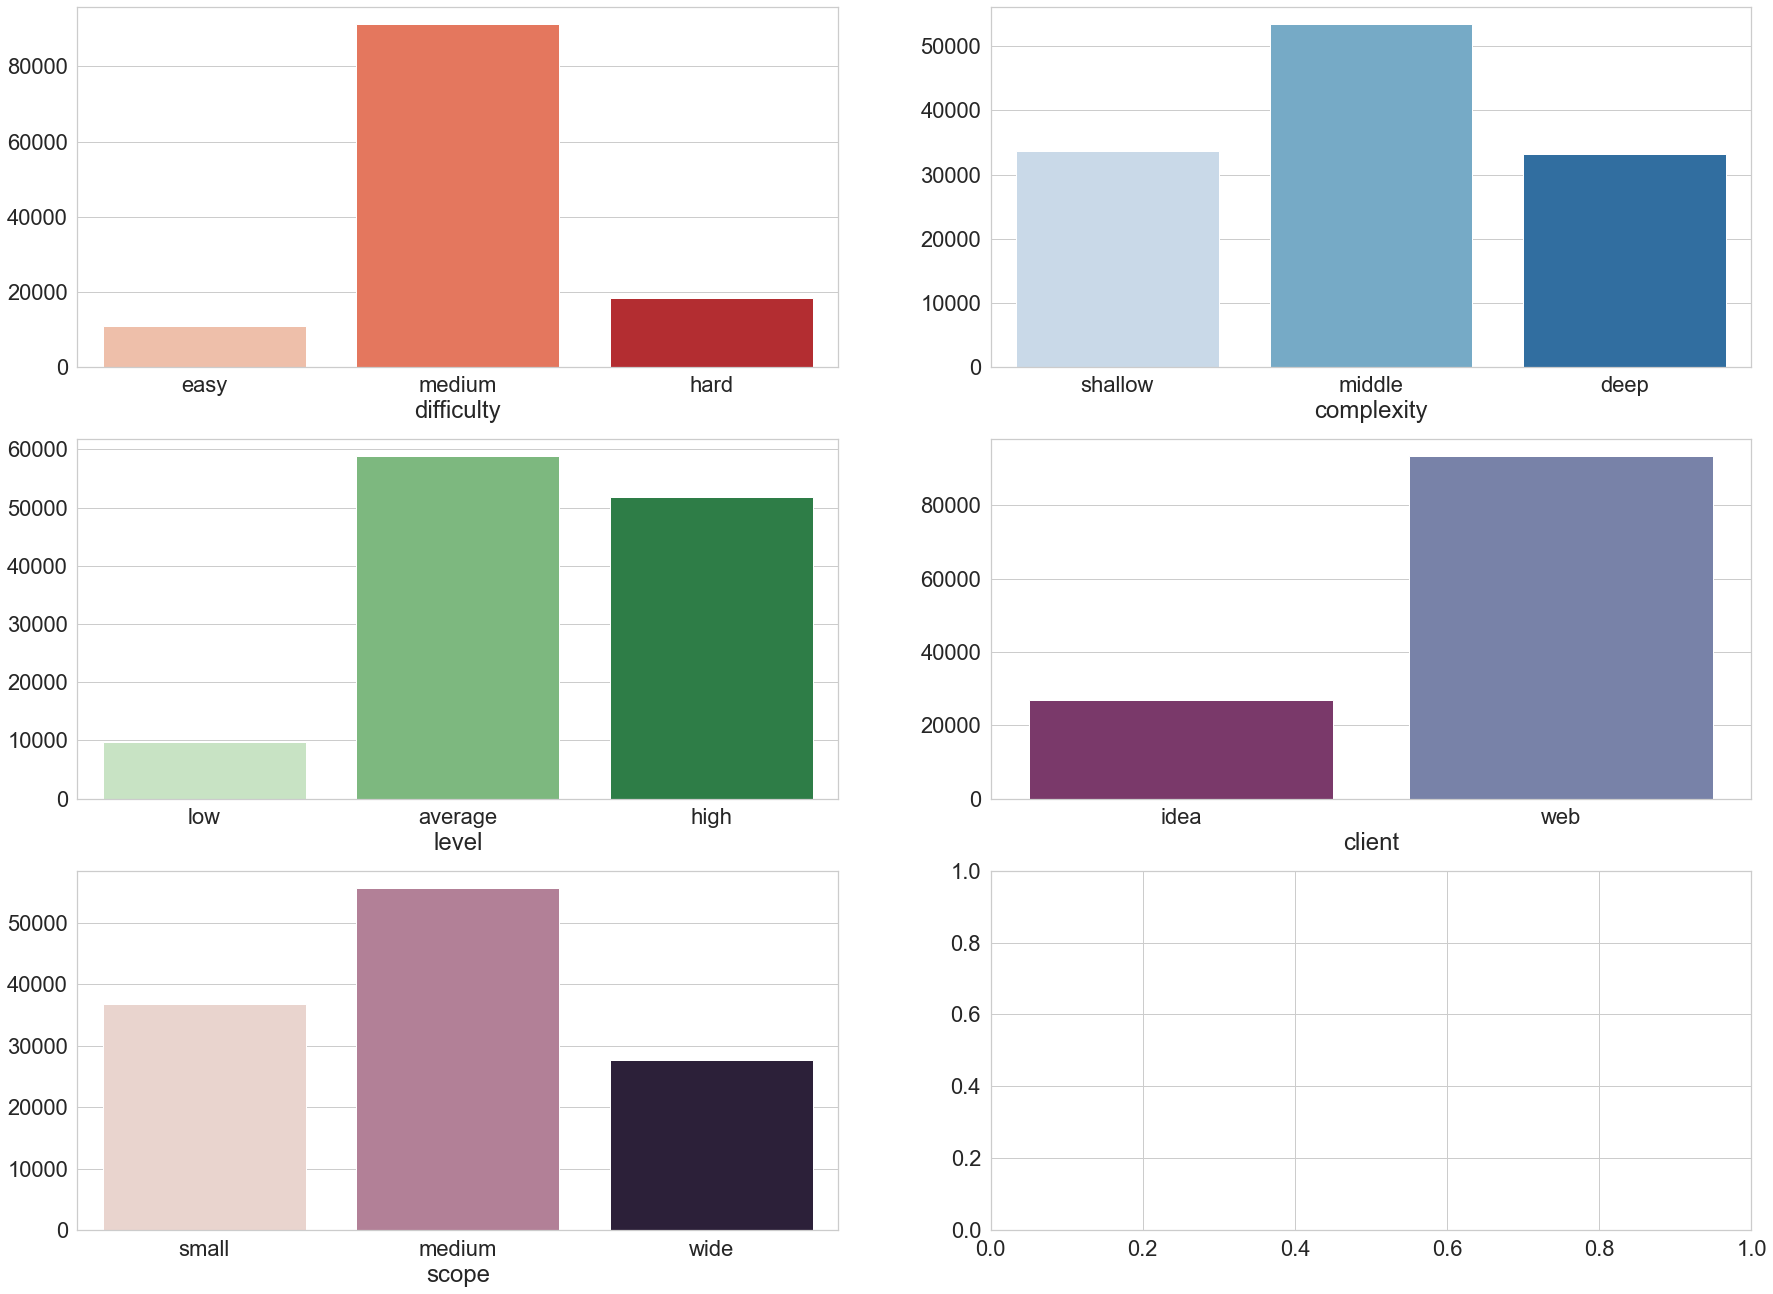

In [71]:
draw_hist_plots(df_last_attempt_stats, ['code_lines_count', 'code_symbols_count'], 
                log_scale=(False, True))
draw_count_plots(df_last_attempt_stats, ['difficulty', 'complexity', 'level', 'client', 'scope'])

In [72]:
df_last_attempt_hyperstyle_issues_stats = merge_dfs(df_last_attempt_stats, 
                                                    df_hyperstyle_issues_stats, 
                                                    left_on='id', right_on='id')

df_last_attempt_hyperstyle_issues_stats_unique = merge_dfs(df_last_attempt_stats, 
                                                           df_hyperstyle_issues_stats_unique, 
                                                           left_on='id', right_on='id')

### Hyperstyle issues analysis in last attempt. Percent of submissions with each issue.

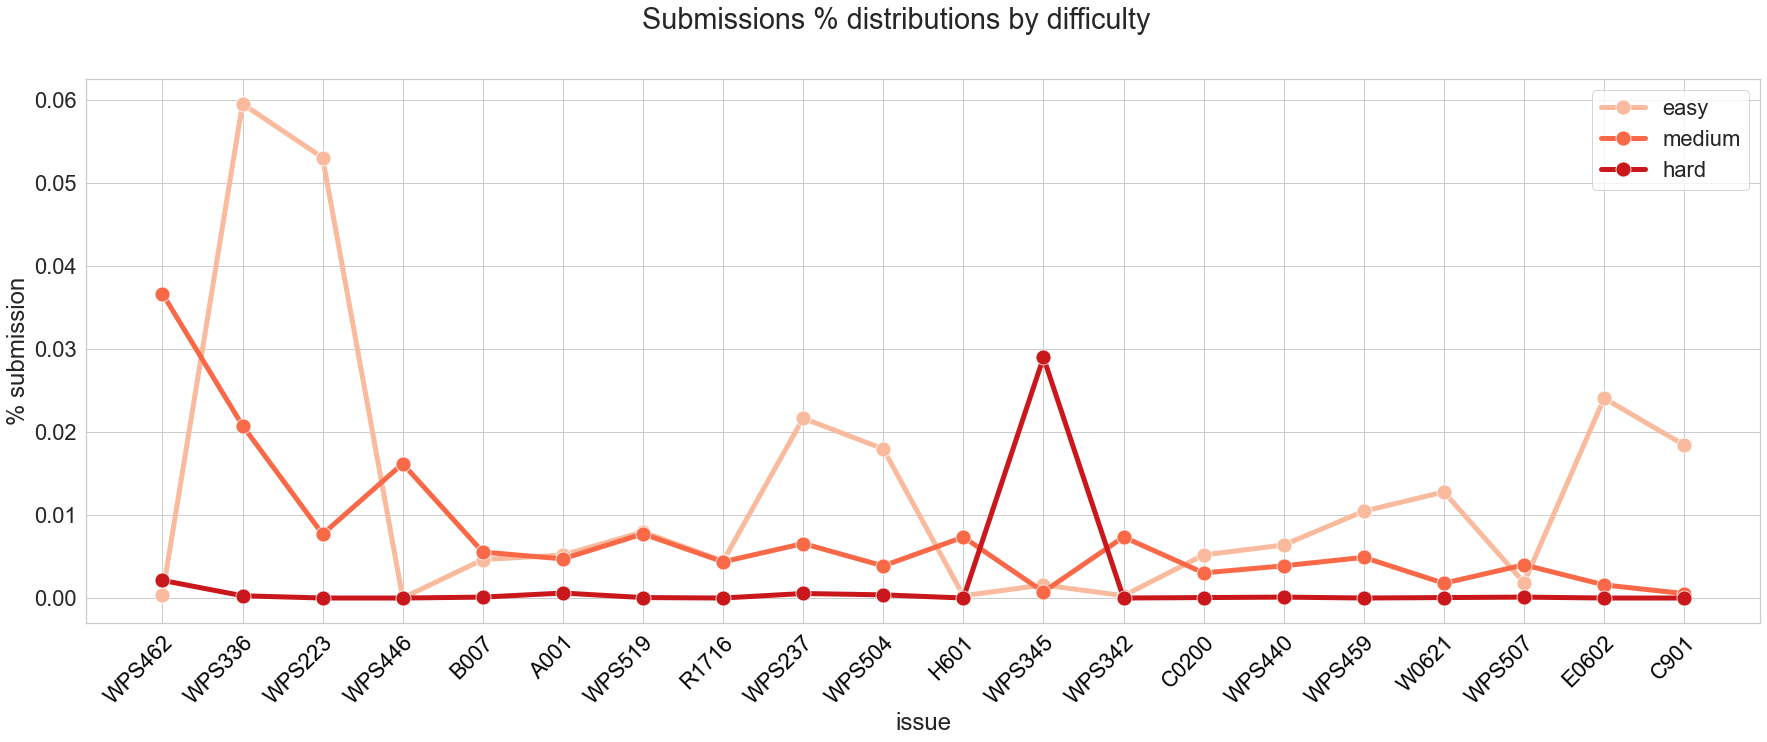

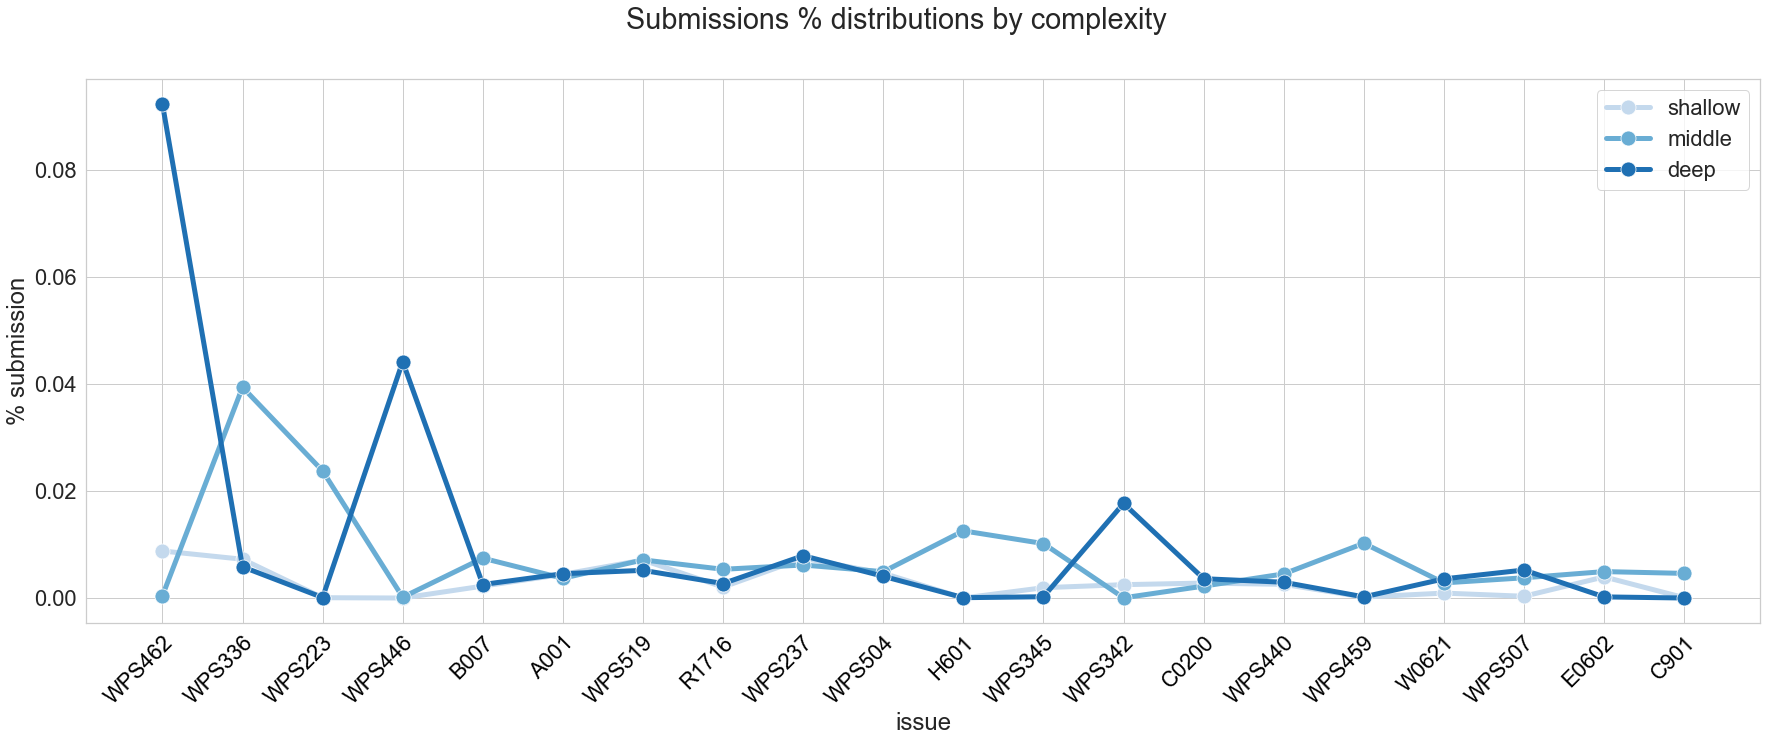

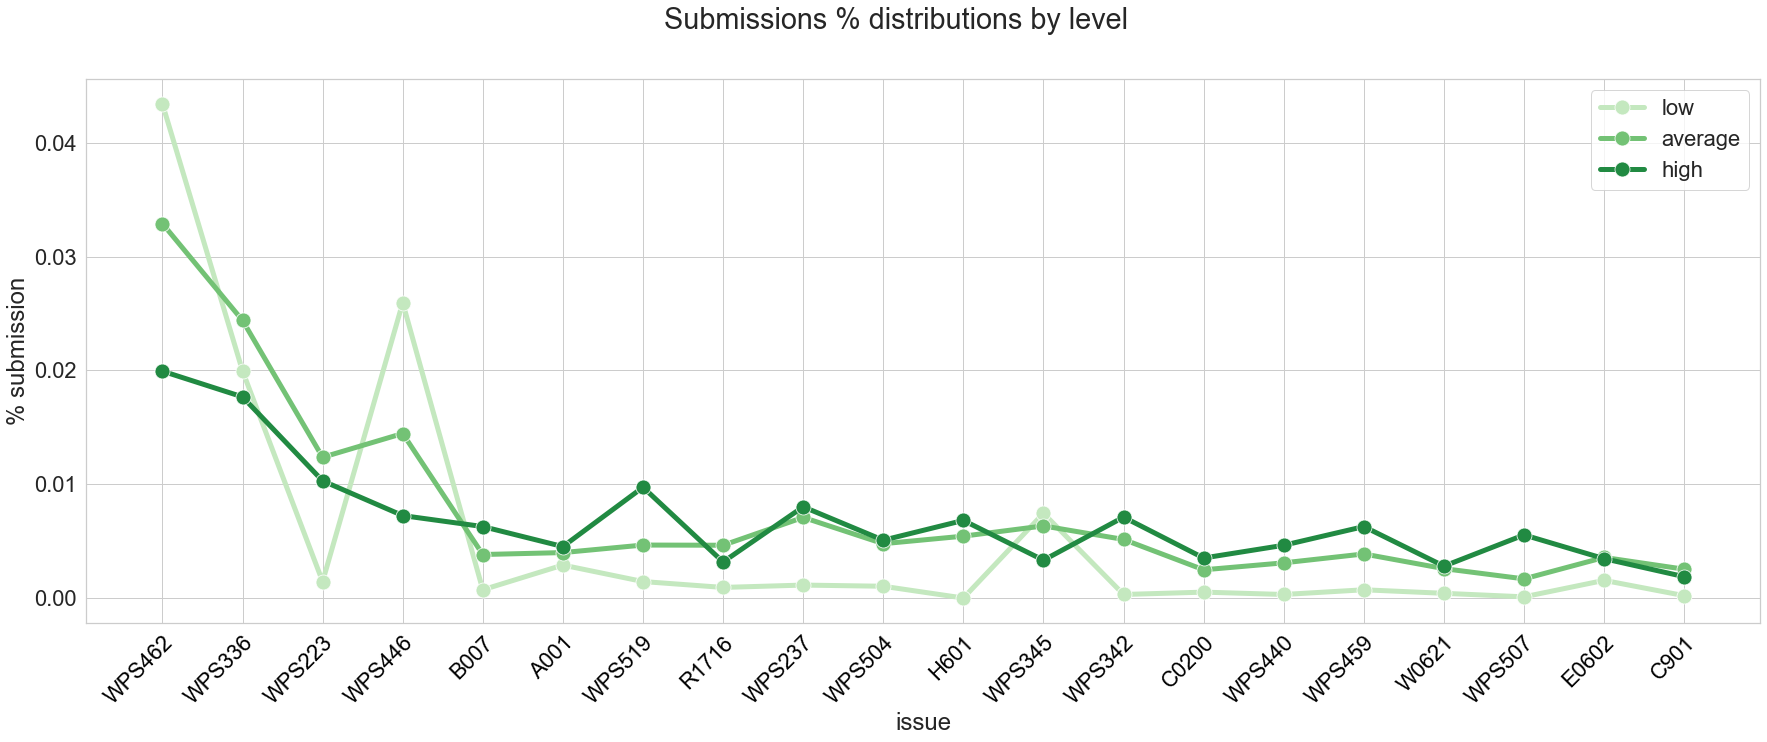

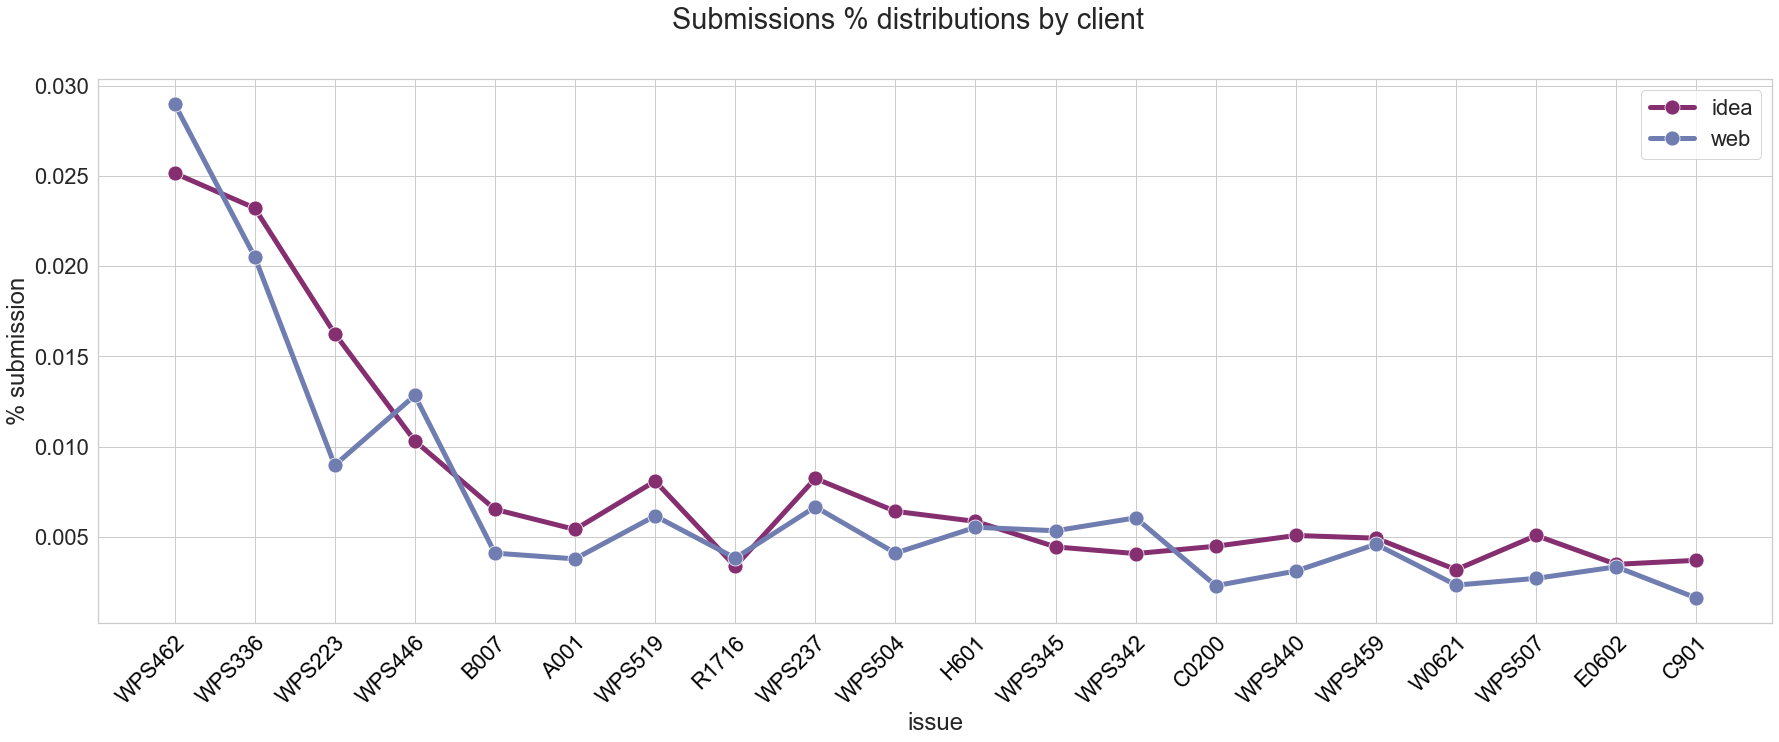

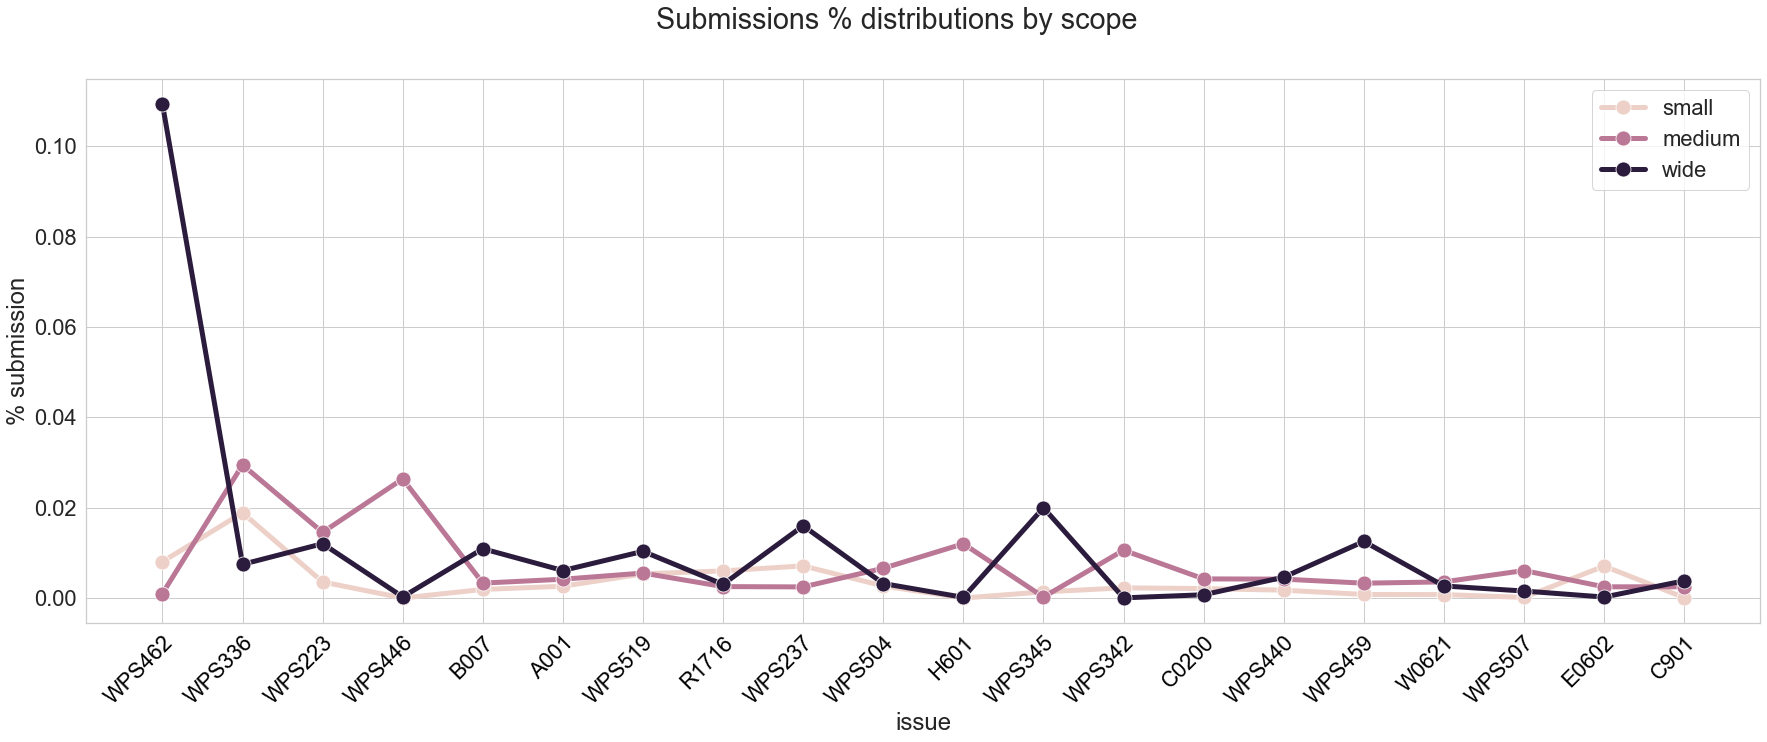

In [73]:
draw_issues(df_last_attempt_hyperstyle_issues_stats_unique, 
            df_hyperstyle_issues_top, 
            hyperstyle_issues_info_names,
            base_dir=os.path.join('hyperstyle', 'issues_last_attempt'))

# Submission series (groups) analysis
To pass the step user can make several attemps. The ordered sequence of attemps in **submission series**. In this section you can find analysis of the student progess on code quality issues fixing. 

### Number of submission series by total number of attempts in series

In [74]:
df_last_attempt_stats['total_attempts'].value_counts()

1    106338
2     10691
3      2306
4       751
5       247
Name: total_attempts, dtype: int64

In [75]:
def draw_feature_dynamic(feature: str, max_attempts: int = 5, exact_attempts: bool = False, is_mean=True):
    for attr in ['difficulty', 'complexity', 'level', 'client', 'scope']:
        df_dynamic = get_submissions_series_dynamic_by_feature(df_submissions_stats, feature, attr, 
                                                               max_attempts=max_attempts)
#         uncomment to save stats to csv
#         df_dynamic.to_csv(f'{feature}_dynamic_{attr}.csv', index=False)
        draw_compare(df_dynamic, 'attempt', attr, y_label=f'mean\n{feature}', title=f'{feature} dynamic by attemps')

## Average number of hyperstyle issues by each attempt
For all submission series, we calculate mean number of issues made on i-th attempt. The plots show that from attempt to attempt the number of issues in students’ solutions decreases, regardless of the parameters of the student, steps on environment.

`exact_attempts` - if True than only submissions with `total_attempt` == `max_attempts` (so the number of submission for each attempt is equal) are selected othwise `total_attempt` <= `max_attempts` (so the number of submission for each attempt is decreasing)

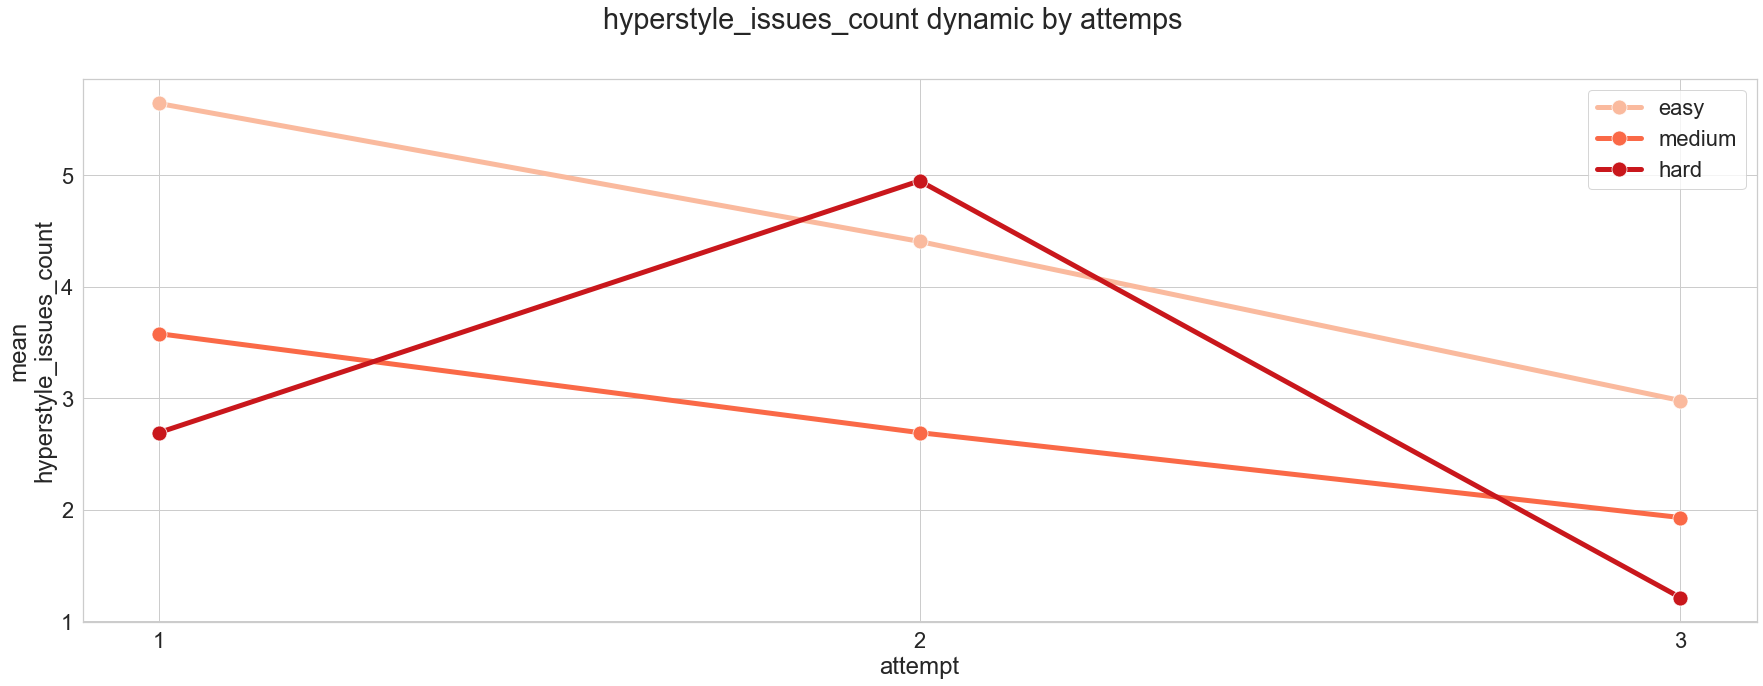

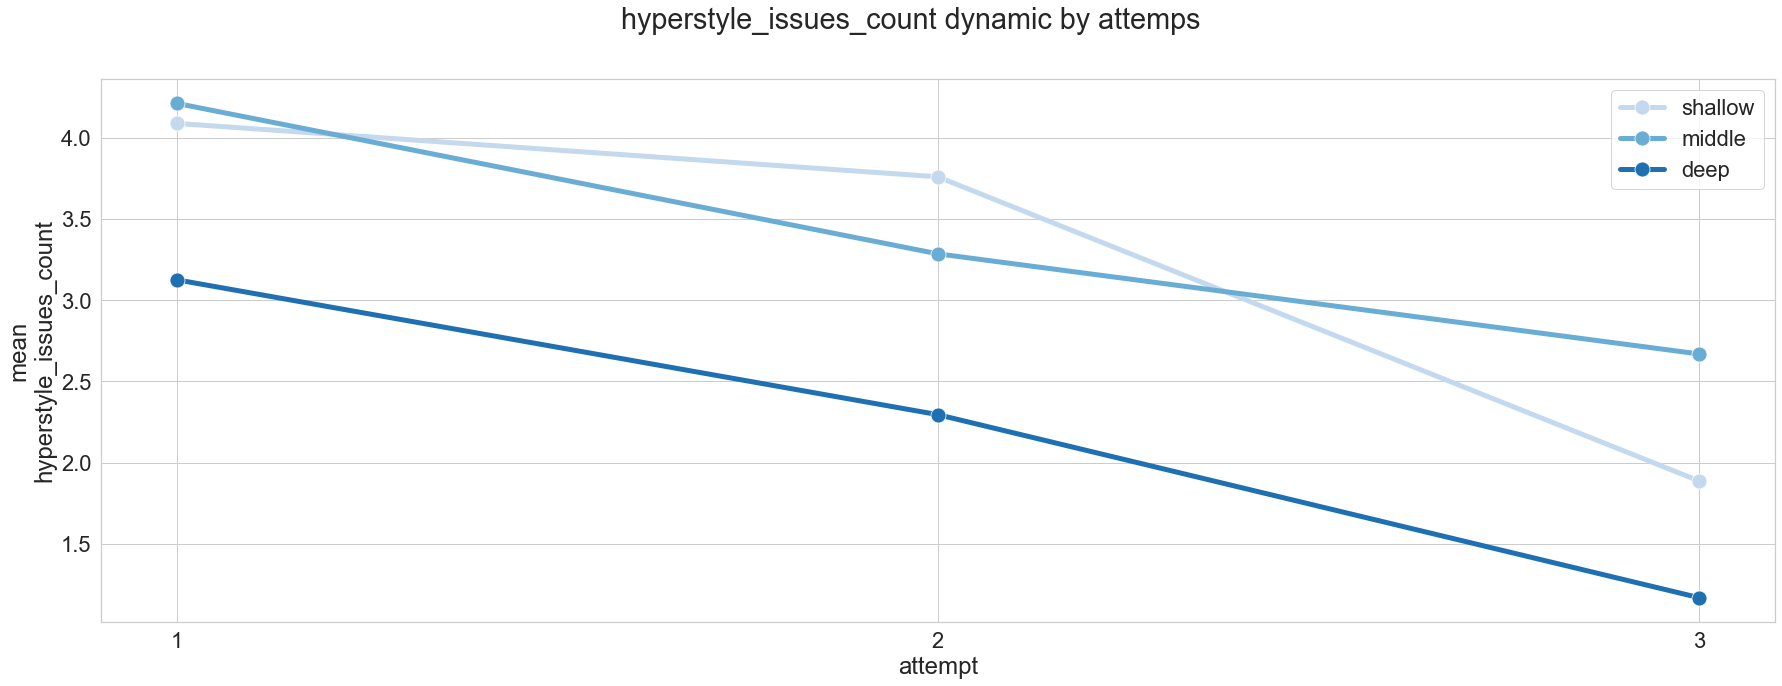

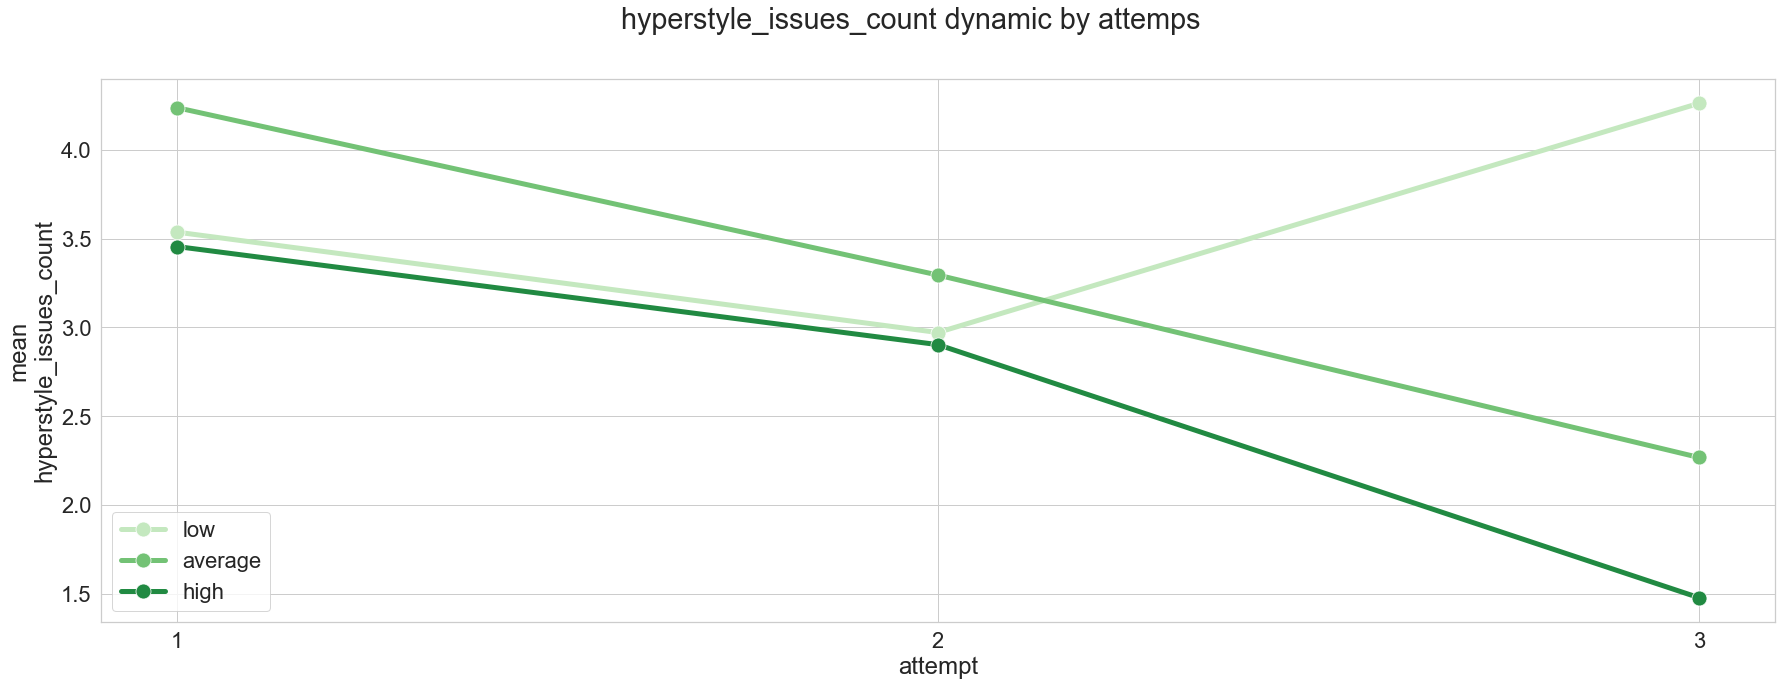

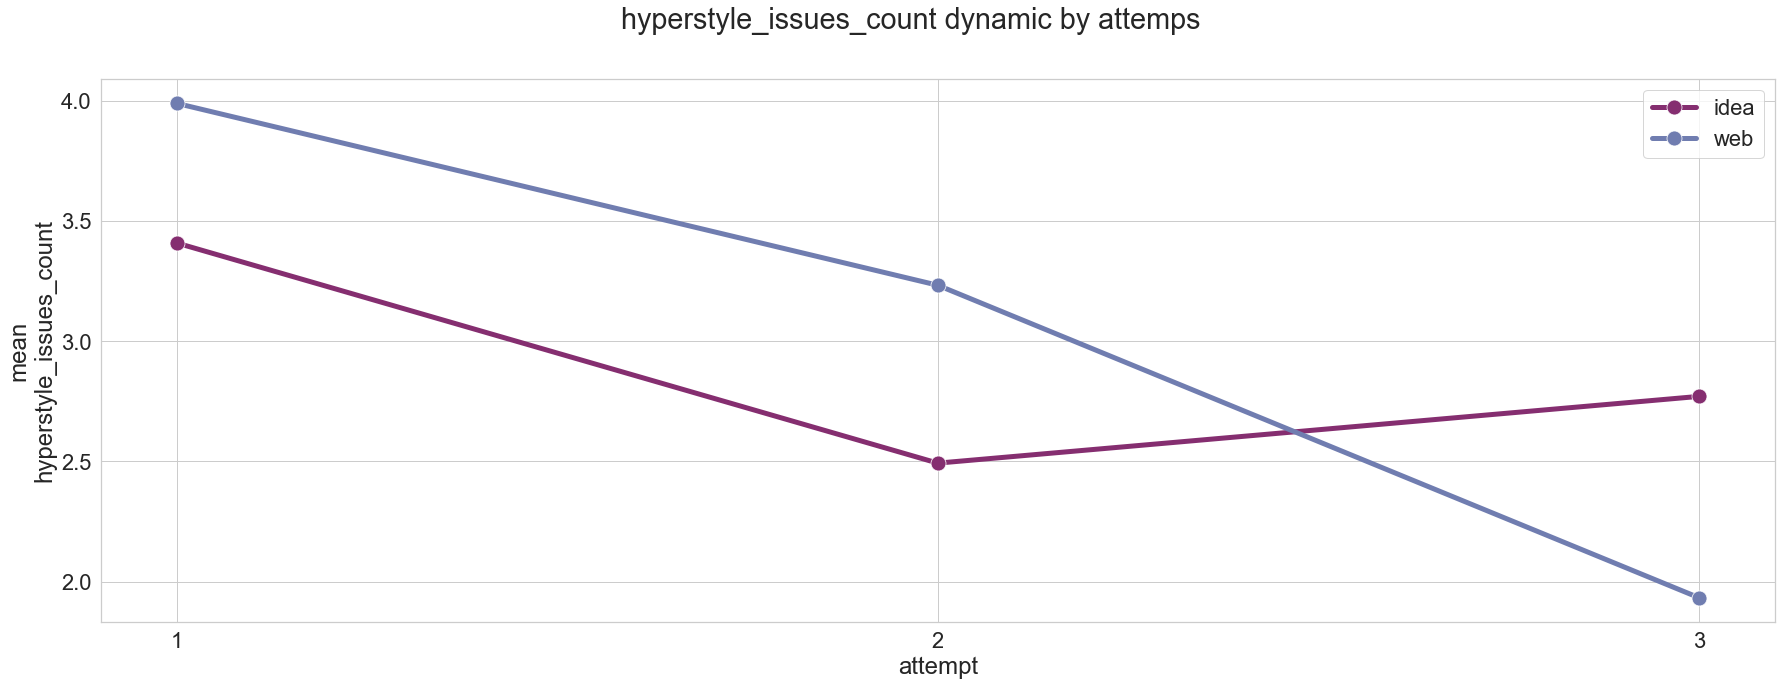

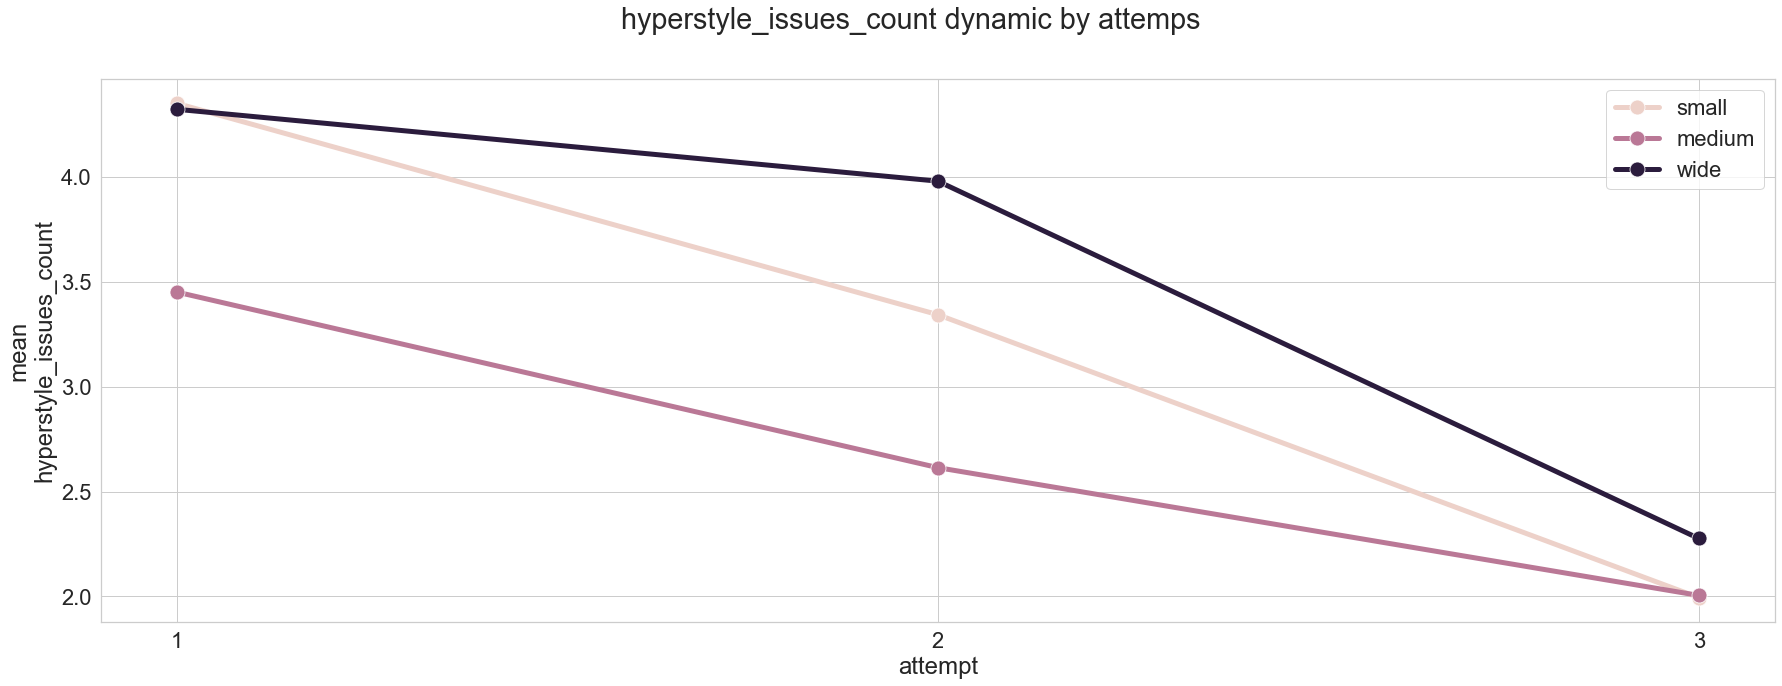

In [76]:
draw_feature_dynamic('hyperstyle_issues_count', max_attempts=3, exact_attempts=True)

## Submissions series dynamic
Plots show how average soution parameters change throught attemps 

### Dynamin for all sobmission series with total_attemps = 5

In [77]:
def draw_issues_dynamic(df: pd.DataFrame, df_issues: pd.DataFrame, max_attempts: int = 5,
                                          exact_attempts: bool = False, by_type=False, is_mean=True):
    df_issues_dynamic = get_submissions_series_issues_dynamic(df, df_issues, max_attempts, exact_attempts, 
                                                              by_type, is_mean)
    df_issues_dynamic.to_csv(f'hyperstyle/issues/issues_dynamic.csv', index=False)
    issues = df_issues['category' if by_type else 'name'].unique()
    draw_compare(df_issues_dynamic, 'attempt', ('issue', issues))
    return df_issues_dynamic.drop(columns=['attempt', 'count']).T

### Hypertyle issues dynamic by attempts (with issue names)
Percent of submission which contains each issue by attempts dynamic. The plot shows that in most cases all issues are decreras but it should be examined more precisely in csv file

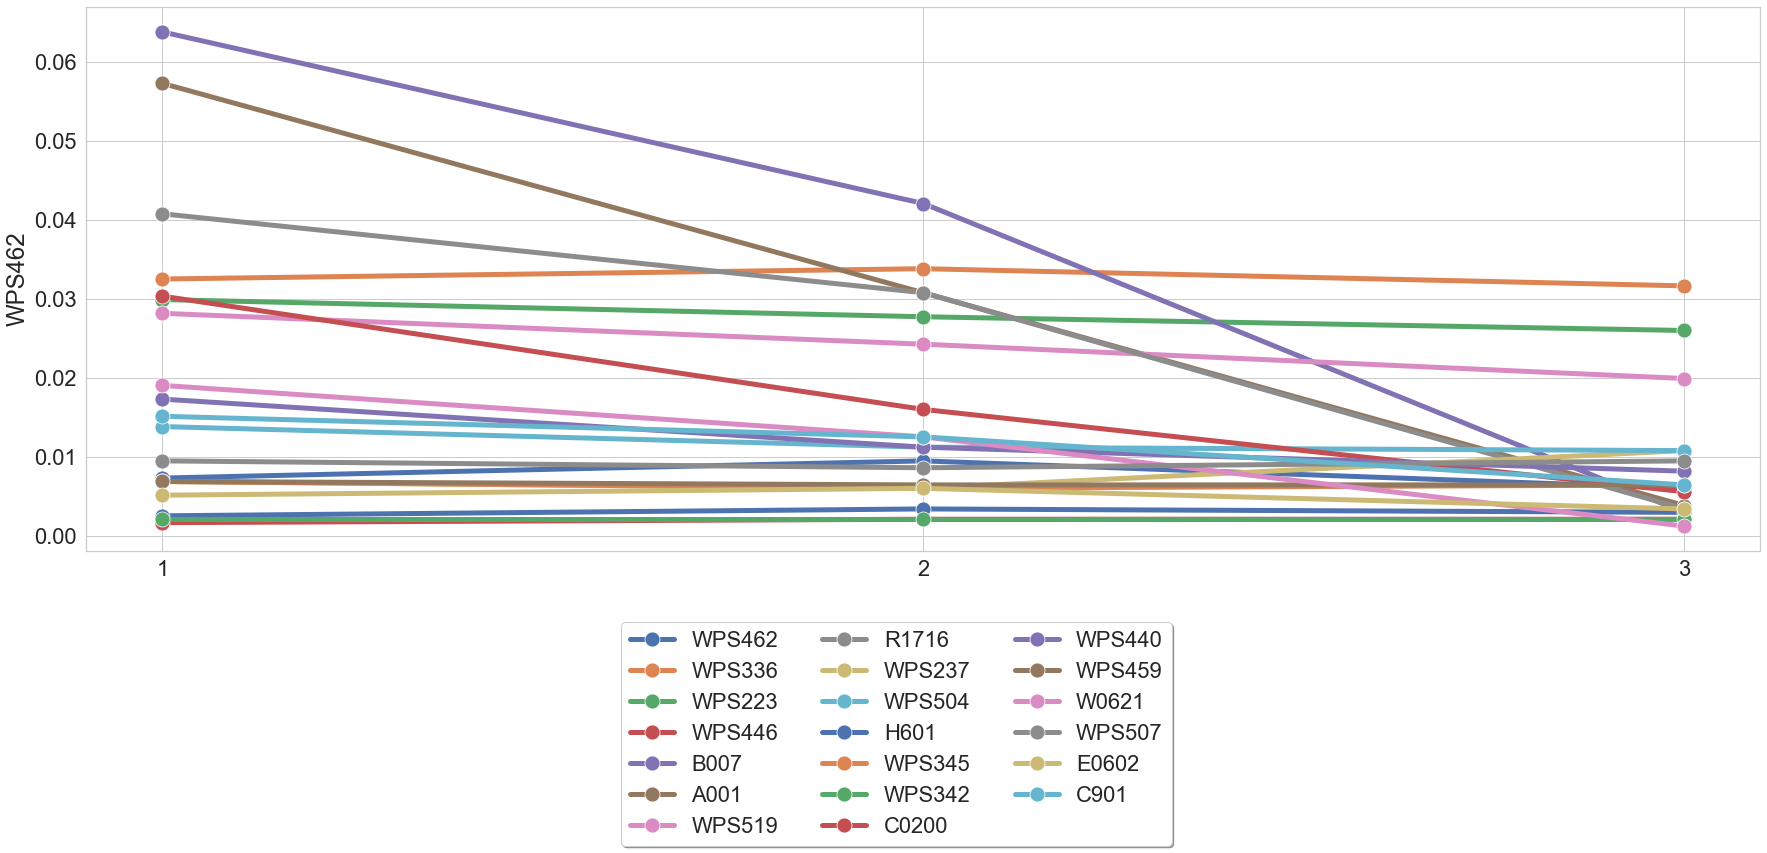

<Figure size 432x288 with 0 Axes>

0         1         2
WPS462  0.007372  0.009540  0.006071
WPS336  0.032524  0.033825  0.031657
WPS223  0.029922  0.027754  0.026019
WPS446  0.001735  0.002168  0.002168
B007    0.063747  0.042064  0.003036
A001    0.057242  0.030789  0.003903
WPS519  0.028187  0.024284  0.019948
R1716   0.040763  0.030789  0.003469
WPS237  0.006938  0.006071  0.010841
WPS504  0.013877  0.011275  0.010841
H601    0.002602  0.003469  0.003036
WPS345  0.006938  0.006071  0.006505
WPS342  0.002168  0.002168  0.002168
C0200   0.030356  0.016045  0.005637
WPS440  0.017346  0.011275  0.008239
WPS459  0.006938  0.006505  0.006505
W0621   0.019081  0.012576  0.001301
WPS507  0.009540  0.008673  0.009540
E0602   0.005204  0.006071  0.003469
C901    0.015178  0.012576  0.006505

In [78]:
draw_issues_dynamic(df_hyperstyle_issues_stats_unique, 
                    df_hyperstyle_issues_top, 
                    max_attempts=3, 
                    exact_attempts=True)

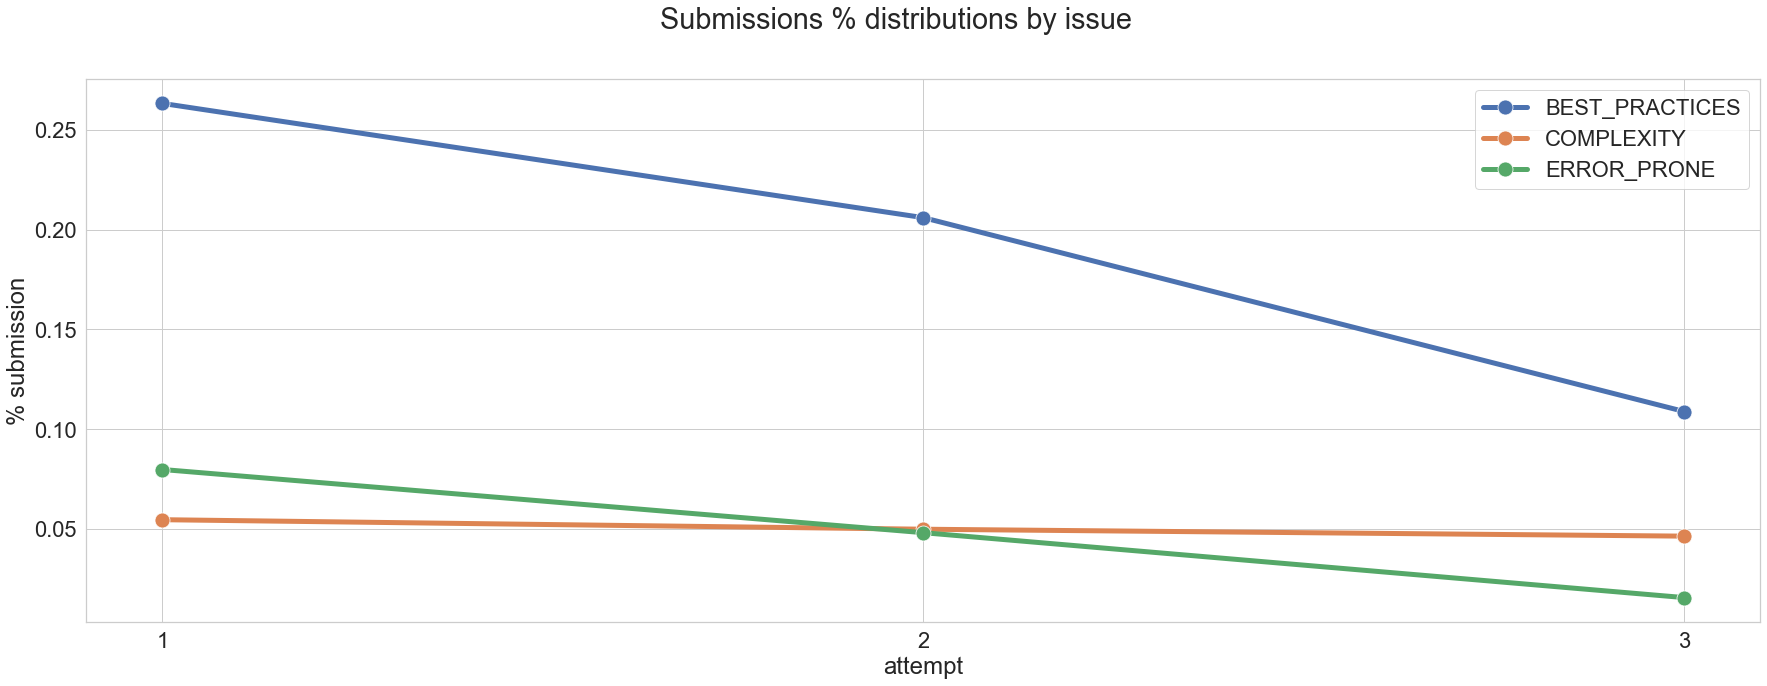

0         1         2
BEST_PRACTICES  0.263226  0.205984  0.108846
COMPLEXITY      0.054640  0.049870  0.046401
ERROR_PRONE     0.079792  0.048135  0.015611

In [79]:
draw_issues_dynamic(df_hyperstyle_issues_stats_unique, 
                    df_hyperstyle_issues_top, 
                    by_type=True, 
                    max_attempts=3, 
                    exact_attempts=True)

In [80]:
importlib.reload(analysis.src.python.data_analysis.stat_test.iticse_2022.rq_stat_tests)

from analysis.src.python.data_analysis.stat_test.iticse_2022.rq_stat_tests import run_stat_tests
from analysis.src.python.data_analysis.model.column_name import SubmissionStatsColumns

df_hyperstyle_issues_stats[SubmissionStatsColumns.HYPERSTYLE_ISSUES_COUNT.value] = \
    df_hyperstyle_issues_stats[df_hyperstyle_issues_top['name'].values].sum(axis=1)

run_stat_tests(df_hyperstyle_issues_stats, 
               df_hyperstyle_issues_top['name'].values,
               ['rq2'])

######################RQ2######################
H0: The number of code quality issues does not decrease over time in submissions chains

######################TOTAL ATTEMPTS COUNT: 3######################
    Source  ddof1  ddof2           F          p-unc     p-GG-corr       np2  \
0  attempt      2   4610  272.382673  1.545675e-112  2.183027e-96  0.105682   

        eps  sphericity   W-spher       p-spher  
0  0.852085       False  0.826408  4.057679e-96  
######################TOTAL ATTEMPTS COUNT: 2######################
    Source  ddof1  ddof2           F          p-unc       np2  eps
0  attempt      1  10690  771.511982  5.136182e-164  0.067313  1.0
######################TOTAL ATTEMPTS COUNT: 4######################
    Source  ddof1  ddof2          F         p-unc     p-GG-corr       np2  \
0  attempt      3   2250  69.490699  5.640567e-43  4.072943e-32  0.084797   

        eps  sphericity   W-spher       p-spher  
0  0.729564       False  0.546414  1.418428e-95  
###########